### 1. Importing packages

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os
import requests
from yfinance import shared
import pandas_datareader as pdr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import random

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

### 2. Loading dataset

In [3]:
## Define the list of tickers
tickers = ['SPY',   # S&P 500 (US Large Cap)
    'QQQ',   # Nasdaq 100 (Tech US)
    'VEA',   # Actions développées hors US
    'BND',   # Obligations US
    'GLD',   # Or
    'IWM',   # US Small Cap
    'VNQ']

## Set the end date to today
end_date = datetime.today()-timedelta(days = 100) 
print(end_date)

## Set the start date to 2 years ago
start_date = end_date - timedelta(days = 7*365)
print(start_date)

2025-03-30 15:54:54.697904
2018-04-01 15:54:54.697904


In [6]:
!pip install alpha_vantage


In [8]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import time

api_key = "Q98LT3UTILFZ8JBV"  # Remplace par ta vraie clé
tickers = ['SPY', 'QQQ', 'VEA', 'BND', 'GLD', 'IWM', 'VNQ']

ts = TimeSeries(key=api_key, output_format='pandas')

data = {}
for symbol in tickers:
    try:
        df, meta = ts.get_daily(symbol=symbol, outputsize='full')
        if not df.empty:
            data[symbol] = df
            print(f"{symbol} téléchargé ({len(df)} lignes)")
        else:
            print(f"{symbol} : données vides.")
    except Exception as e:
        print(f"Erreur pour {symbol}: {e}")
    time.sleep(12)  # Important ! Limite Alpha Vantage: 5 requêtes/minute

# Exemple d'accès : afficher les 5 premières lignes de SPY
if 'SPY' in data:
    print(data['SPY'].head())





SPY téléchargé (6458 lignes)
QQQ téléchargé (6458 lignes)
VEA téléchargé (4515 lignes)
BND téléchargé (4590 lignes)
GLD téléchargé (5189 lignes)
IWM téléchargé (6314 lignes)
VNQ téléchargé (5225 lignes)
            1. open  2. high  3. low  4. close   5. volume
date                                                      
2025-07-07   623.36   624.03  617.87    620.68  74814505.0
2025-07-03   622.45   626.28  622.43    625.34  51065789.0
2025-07-02   617.24   620.49  616.61    620.45  66510374.0
2025-07-01   616.36   618.83  615.52    617.65  70030140.0
2025-06-30   617.38   619.22  615.04    617.85  92502541.0


In [9]:
print(data)

{'SPY':              1. open   2. high    3. low  4. close   5. volume
date                                                          
2025-07-07  623.3600  624.0300  617.8700  620.6800  74814505.0
2025-07-03  622.4500  626.2800  622.4300  625.3400  51065789.0
2025-07-02  617.2400  620.4900  616.6100  620.4500  66510374.0
2025-07-01  616.3600  618.8300  615.5200  617.6500  70030140.0
2025-06-30  617.3800  619.2200  615.0400  617.8500  92502541.0
...              ...       ...       ...       ...         ...
1999-11-05  138.6250  139.1093  136.7812  137.8750   7431500.0
1999-11-04  136.7500  137.3593  135.7656  136.5312   7907500.0
1999-11-03  136.0000  136.3750  135.1250  135.5000   7222300.0
1999-11-02  135.9687  137.2500  134.5937  134.5937   6516900.0
1999-11-01  136.5000  137.0000  135.5625  135.5625   4006500.0

[6458 rows x 5 columns], 'QQQ':             1. open  2. high  3. low  4. close   5. volume
date                                                      
2025-07-07   553.52   

In [10]:
close_prices = pd.DataFrame({symbol: df['4. close'] for symbol, df in data.items()})
print(close_prices)


                 SPY     QQQ    VEA    BND     GLD     IWM    VNQ
date                                                             
1999-11-01  135.5625  130.80    NaN    NaN     NaN     NaN    NaN
1999-11-02  134.5937  130.90    NaN    NaN     NaN     NaN    NaN
1999-11-03  135.5000  133.50    NaN    NaN     NaN     NaN    NaN
1999-11-04  136.5312  135.00    NaN    NaN     NaN     NaN    NaN
1999-11-05  137.8750  136.40    NaN    NaN     NaN     NaN    NaN
...              ...     ...    ...    ...     ...     ...    ...
2025-06-30  617.8500  551.64  57.01  73.63  304.83  215.79  89.06
2025-07-01  617.6500  546.99  56.97  73.34  307.55  218.01  89.71
2025-07-02  620.4500  550.80  57.15  73.26  309.25  221.03  89.92
2025-07-03  625.3400  556.22  57.22  73.08  307.14  223.08  90.02
2025-07-07  620.6800  552.03  56.51  72.84  307.37  219.73  89.25

[6458 rows x 7 columns]


In [11]:
close_prices = close_prices.dropna()
print (close_prices)

               SPY     QQQ    VEA    BND     GLD     IWM    VNQ
date                                                           
2007-07-26  148.02   48.98  47.90  74.71   65.65   78.46  66.31
2007-07-27  145.11   47.99  47.21  74.65   65.41   76.63  64.11
2007-07-30  147.38   48.55  47.96  74.58   65.77   77.96  65.35
2007-07-31  145.72   47.53  47.90  74.73   65.79   77.10  65.09
2007-08-01  146.43   47.90  48.10  74.39   65.93   77.52  65.95
...            ...     ...    ...    ...     ...     ...    ...
2025-06-30  617.85  551.64  57.01  73.63  304.83  215.79  89.06
2025-07-01  617.65  546.99  56.97  73.34  307.55  218.01  89.71
2025-07-02  620.45  550.80  57.15  73.26  309.25  221.03  89.92
2025-07-03  625.34  556.22  57.22  73.08  307.14  223.08  90.02
2025-07-07  620.68  552.03  56.51  72.84  307.37  219.73  89.25

[4515 rows x 7 columns]


In [12]:
close_prices = close_prices.sort_index()


In [13]:
returns = close_prices.pct_change().dropna()
print(returns)
import pandas as pd

# Calcul statistique par actif
stats = pd.DataFrame({
    'Moyenne': returns.mean(),
    'Ecart-type': returns.std(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

# Mise en forme
stats = stats.round(4)
print(stats)


                 SPY       QQQ       VEA       BND       GLD       IWM  \
date                                                                     
2007-07-27 -0.019660 -0.020212 -0.014405 -0.000803 -0.003656 -0.023324   
2007-07-30  0.015643  0.011669  0.015886 -0.000938  0.005504  0.017356   
2007-07-31 -0.011263 -0.021009 -0.001251  0.002011  0.000304 -0.011031   
2007-08-01  0.004872  0.007785  0.004175 -0.004550  0.002128  0.005447   
2007-08-02  0.007990  0.009186 -0.002911  0.001748 -0.000607  0.007869   
...              ...       ...       ...       ...       ...       ...   
2025-06-30  0.004781  0.006477  0.003167  0.003954  0.011985  0.001439   
2025-07-01 -0.000324 -0.008429 -0.000702 -0.003939  0.008923  0.010288   
2025-07-02  0.004533  0.006965  0.003160 -0.001091  0.005528  0.013853   
2025-07-03  0.007881  0.009840  0.001225 -0.002457 -0.006823  0.009275   
2025-07-07 -0.007452 -0.007533 -0.012408 -0.003284  0.000749 -0.015017   

                 VNQ  
date          

SPY    QQQ    VEA    BND    GLD    IWM    VNQ
SPY  1.000  0.924  0.881 -0.013  0.044  0.895  0.752
QQQ  0.924  1.000  0.786 -0.018  0.034  0.823  0.642
VEA  0.881  0.786  1.000  0.019  0.150  0.815  0.688
BND -0.013 -0.018  0.019  1.000  0.223 -0.045  0.018
GLD  0.044  0.034  0.150  0.223  1.000  0.039  0.054
IWM  0.895  0.823  0.815 -0.045  0.039  1.000  0.771
VNQ  0.752  0.642  0.688  0.018  0.054  0.771  1.000

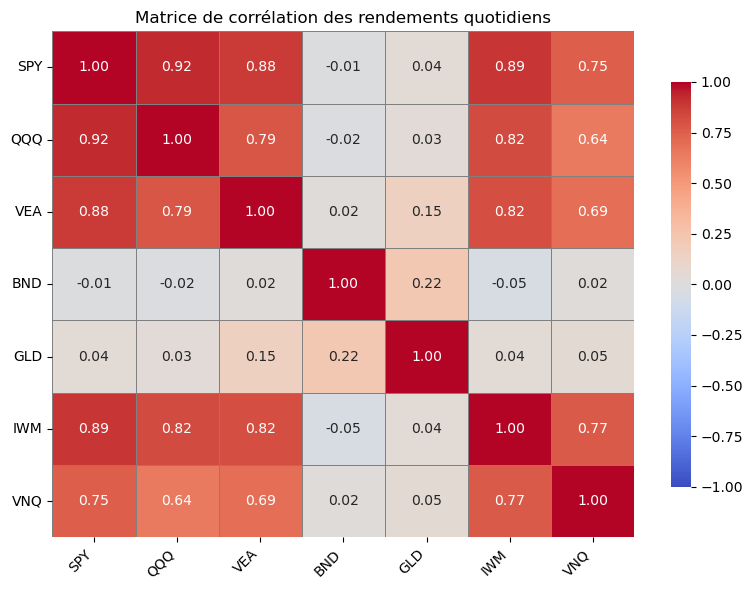

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que `returns` est un DataFrame dont les colonnes sont les tickers et les lignes les dates

# 1. Calcul de la matrice de corrélation
corr_matrix = returns.corr()

# 2. Affichage textuel dans le notebook (tableau)
display(corr_matrix.round(3))

# 3. Visualisation graphique avec une heatmap professionnelle
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, 
    linewidths=0.5, linecolor='grey', cbar_kws={"shrink": 0.8}
)
plt.title("Matrice de corrélation des rendements quotidiens")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


SPY: max abs return = 0.145
QQQ: max abs return = 0.122
VEA: max abs return = 0.153
BND: max abs return = 0.054
GLD: max abs return = 0.113
IWM: max abs return = 0.133
VNQ: max abs return = 0.195


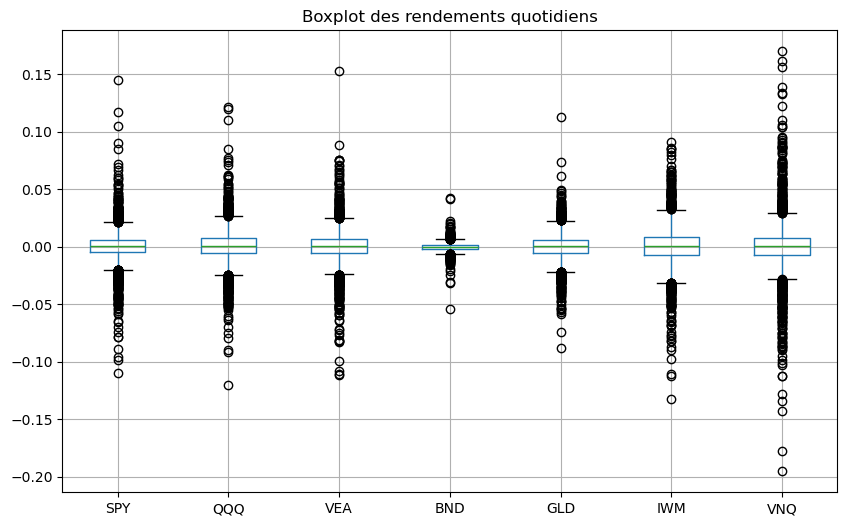

In [15]:
import numpy as np

for col in returns.columns:
    print(f"{col}: max abs return = {returns[col].abs().max():.3f}")

import matplotlib.pyplot as plt
returns.boxplot(figsize=(10, 6))
plt.title("Boxplot des rendements quotidiens")
plt.show()


In [16]:
import numpy as np
import pandas as pd

outlier_percentages = {}

for ticker in returns.columns:
    mean = returns[ticker].mean()
    std = returns[ticker].std()
    z_scores = (returns[ticker] - mean) / std
    outlier_mask = np.abs(z_scores) > 3
    outlier_years = pd.Series(returns.index[outlier_mask].year)  # <--- transformation ici

    total_outliers = len(outlier_years)
    pct_2008 = ( (outlier_years == 2008).sum() / total_outliers * 100) if total_outliers > 0 else 0
    pct_2009 = ( (outlier_years == 2009).sum() / total_outliers * 100) if total_outliers > 0 else 0
    pct_2020 = ( (outlier_years == 2020).sum() / total_outliers * 100) if total_outliers > 0 else 0
    total = pct_2008 + pct_2009 + pct_2020
    outlier_percentages[ticker] = {
        '2008': round(pct_2008, 2),
        '2009': round(pct_2009, 2),
        '2020': round(pct_2020, 2)
    }

    print(f"{ticker}: % outliers 2008 = {pct_2008:.2f}%, 2009 = {pct_2009:.2f}%, 2020 = {pct_2020:.2f}%, total= {total:.2f}%  (sur {total_outliers} outliers)")


SPY: % outliers 2008 = 35.53%, 2009 = 14.47%, 2020 = 22.37%, total= 72.37%  (sur 76 outliers)
QQQ: % outliers 2008 = 34.33%, 2009 = 4.48%, 2020 = 26.87%, total= 65.67%  (sur 67 outliers)
VEA: % outliers 2008 = 42.31%, 2009 = 15.38%, 2020 = 15.38%, total= 73.08%  (sur 78 outliers)
BND: % outliers 2008 = 31.37%, 2009 = 5.88%, 2020 = 21.57%, total= 58.82%  (sur 51 outliers)
GLD: % outliers 2008 = 36.84%, 2009 = 10.53%, 2020 = 10.53%, total= 57.89%  (sur 57 outliers)
IWM: % outliers 2008 = 38.03%, 2009 = 14.08%, 2020 = 18.31%, total= 70.42%  (sur 71 outliers)
VNQ: % outliers 2008 = 44.00%, 2009 = 37.00%, 2020 = 14.00%, total= 95.00%  (sur 100 outliers)


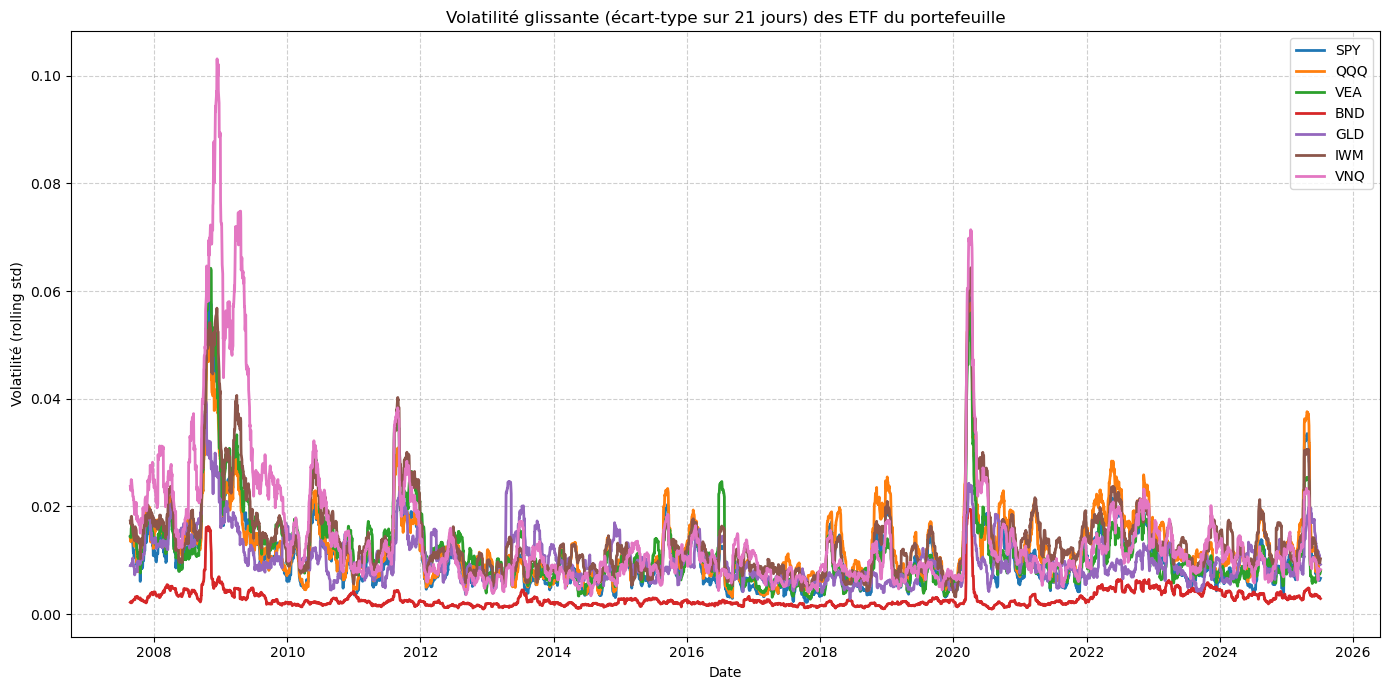

In [17]:
import matplotlib.pyplot as plt

window = 21  # 21 jours = environ 1 mois boursier

plt.figure(figsize=(14, 7))
for col in returns.columns:
    plt.plot(
        returns.index,
        returns[col].rolling(window=window).std(),
        label=col,
        linewidth=2
    )

plt.title("Volatilité glissante (écart-type sur 21 jours) des ETF du portefeuille")
plt.xlabel("Date")
plt.ylabel("Volatilité (rolling std)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [18]:
# plotting parameters
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

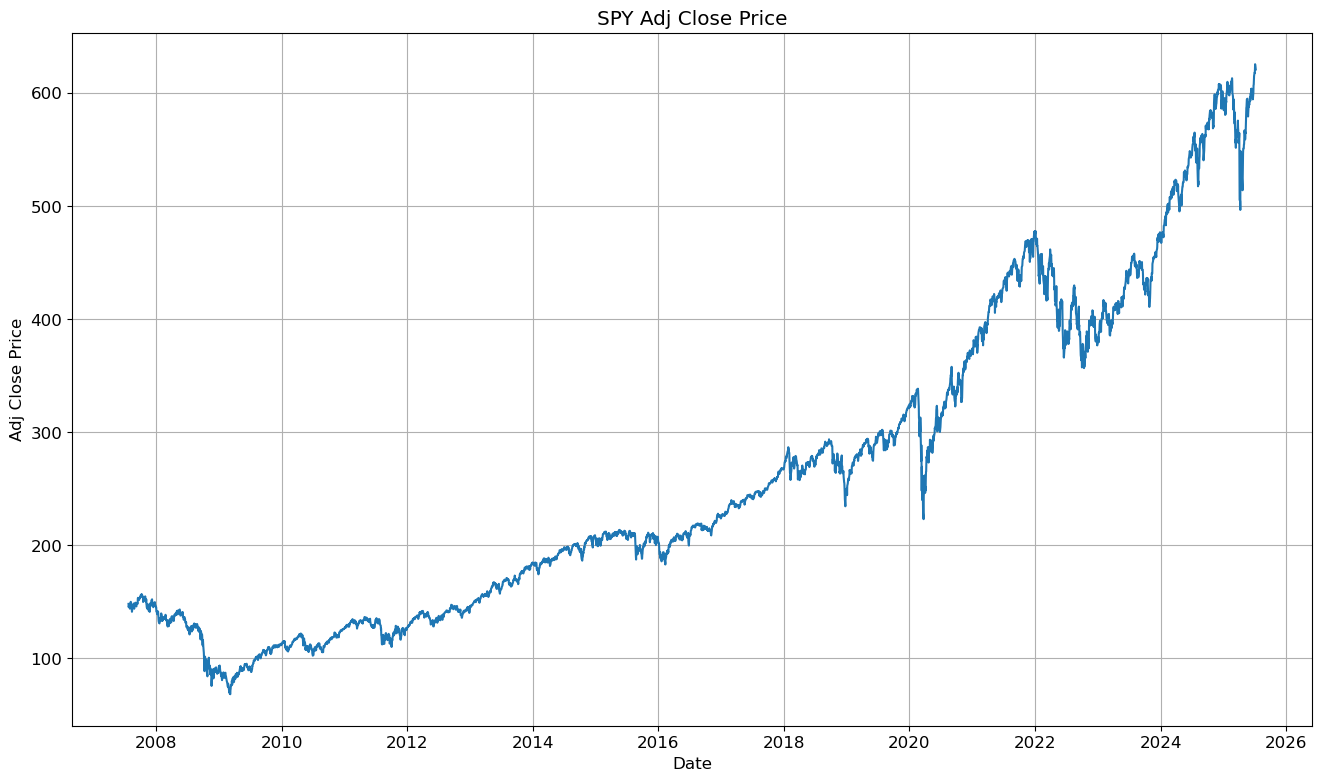

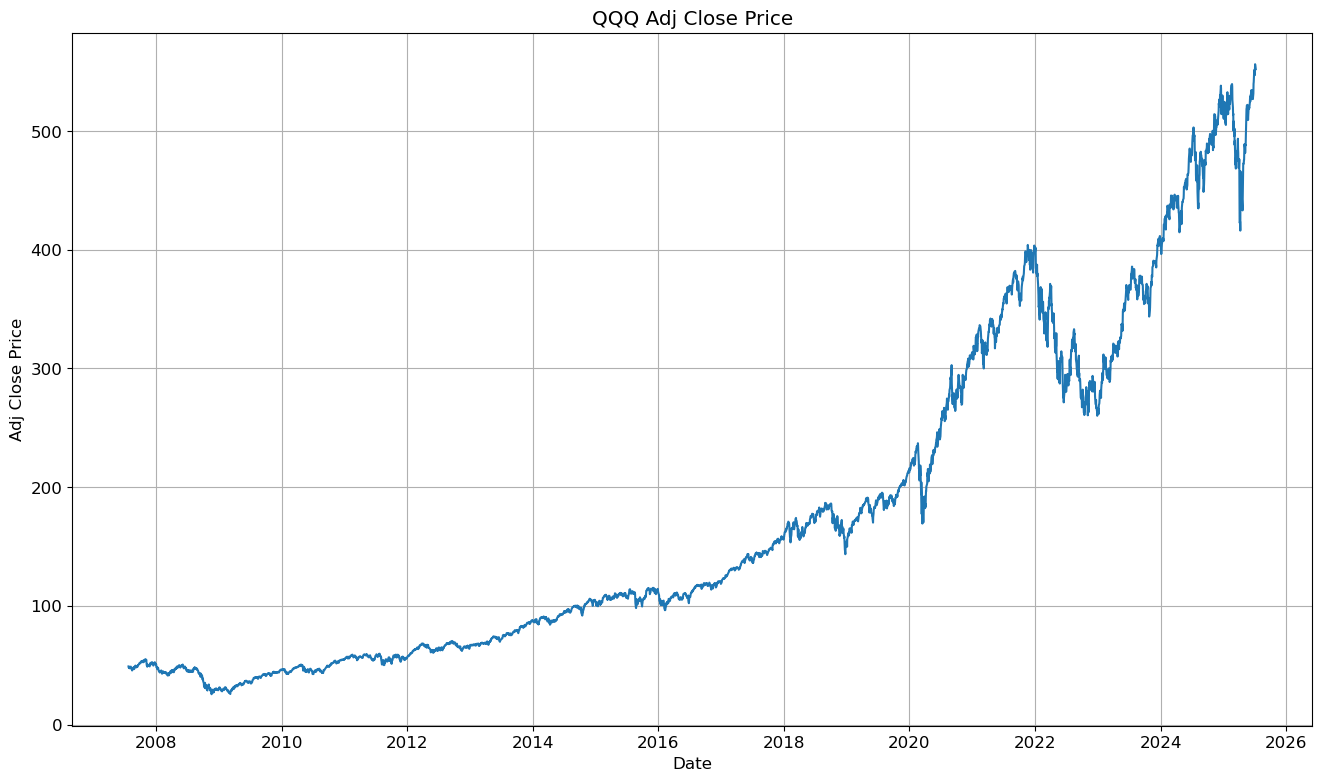

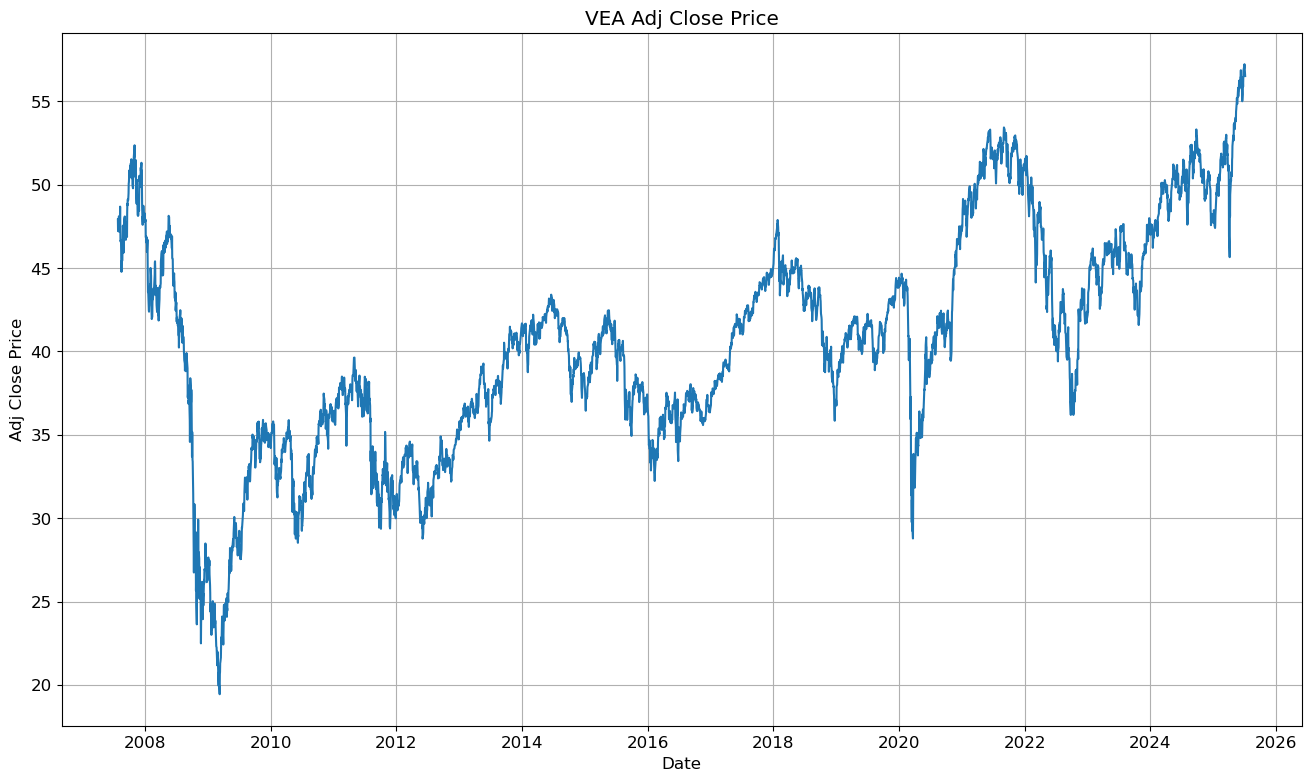

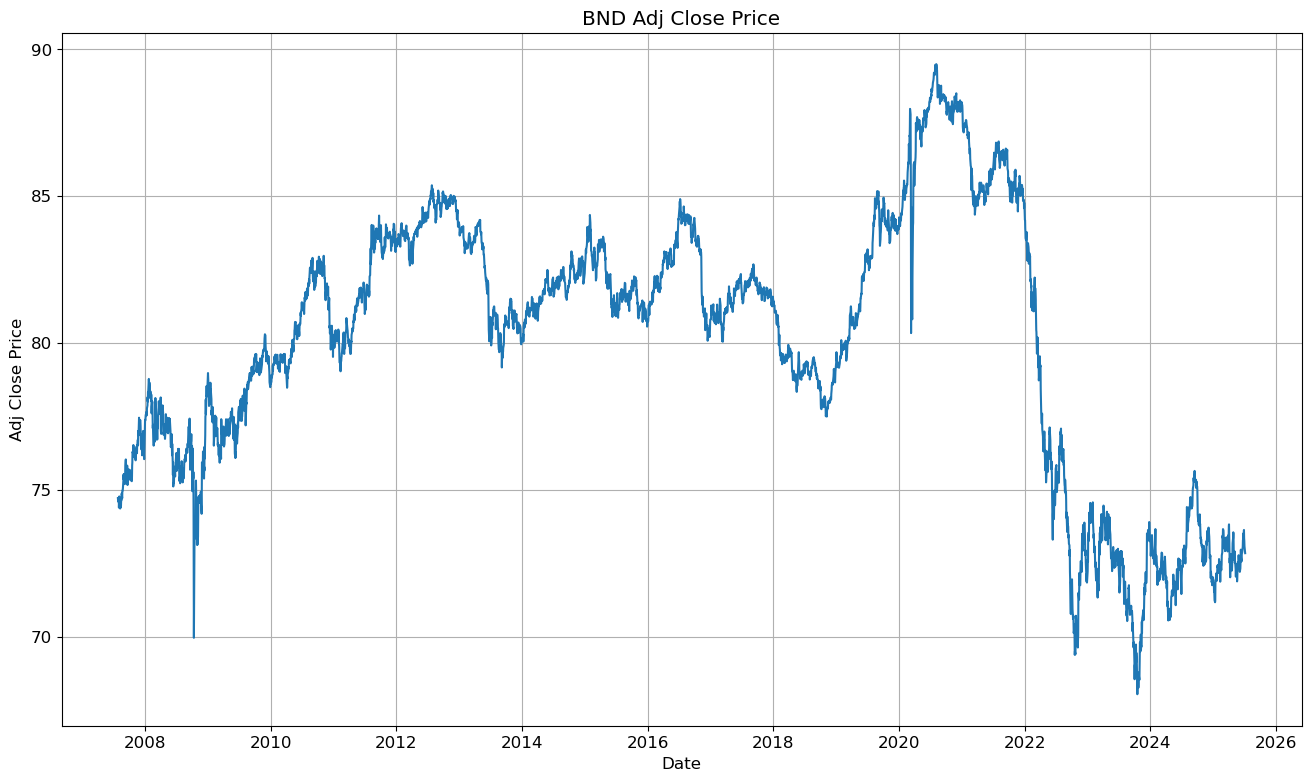

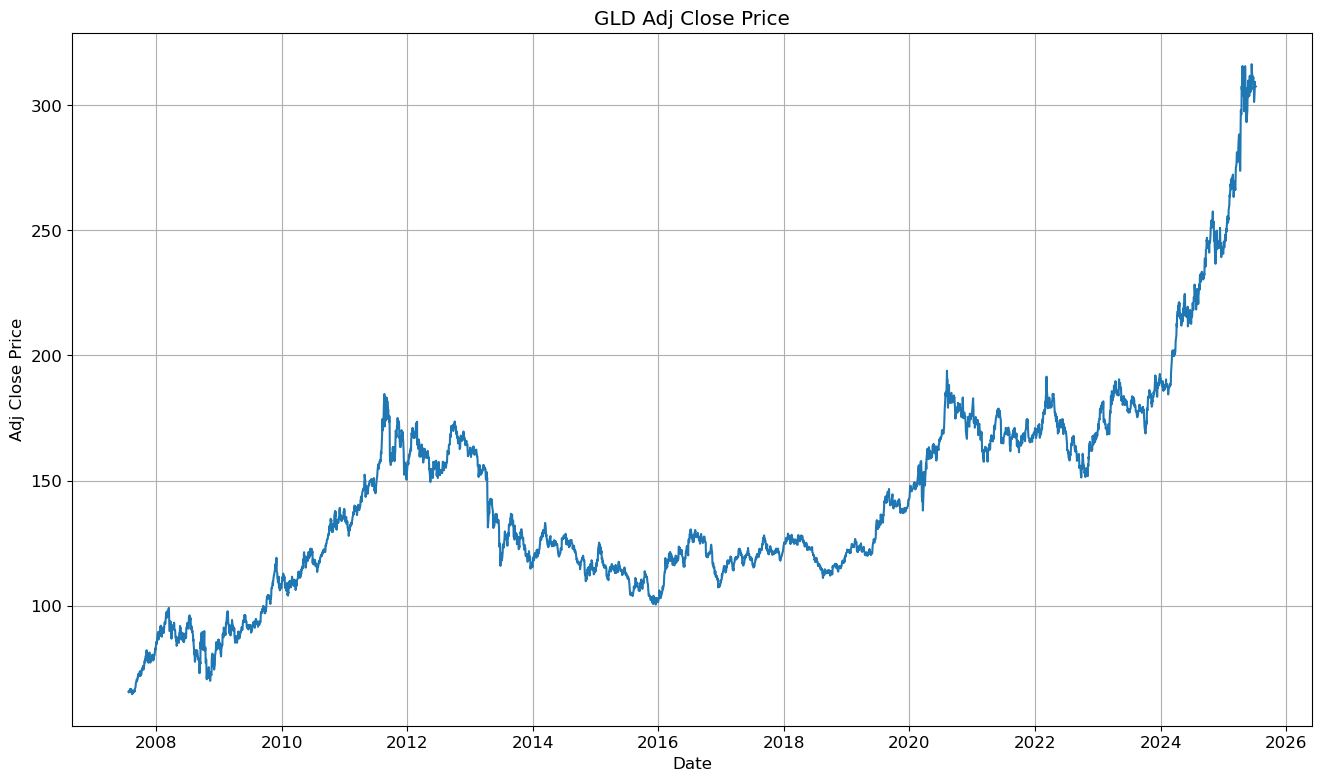

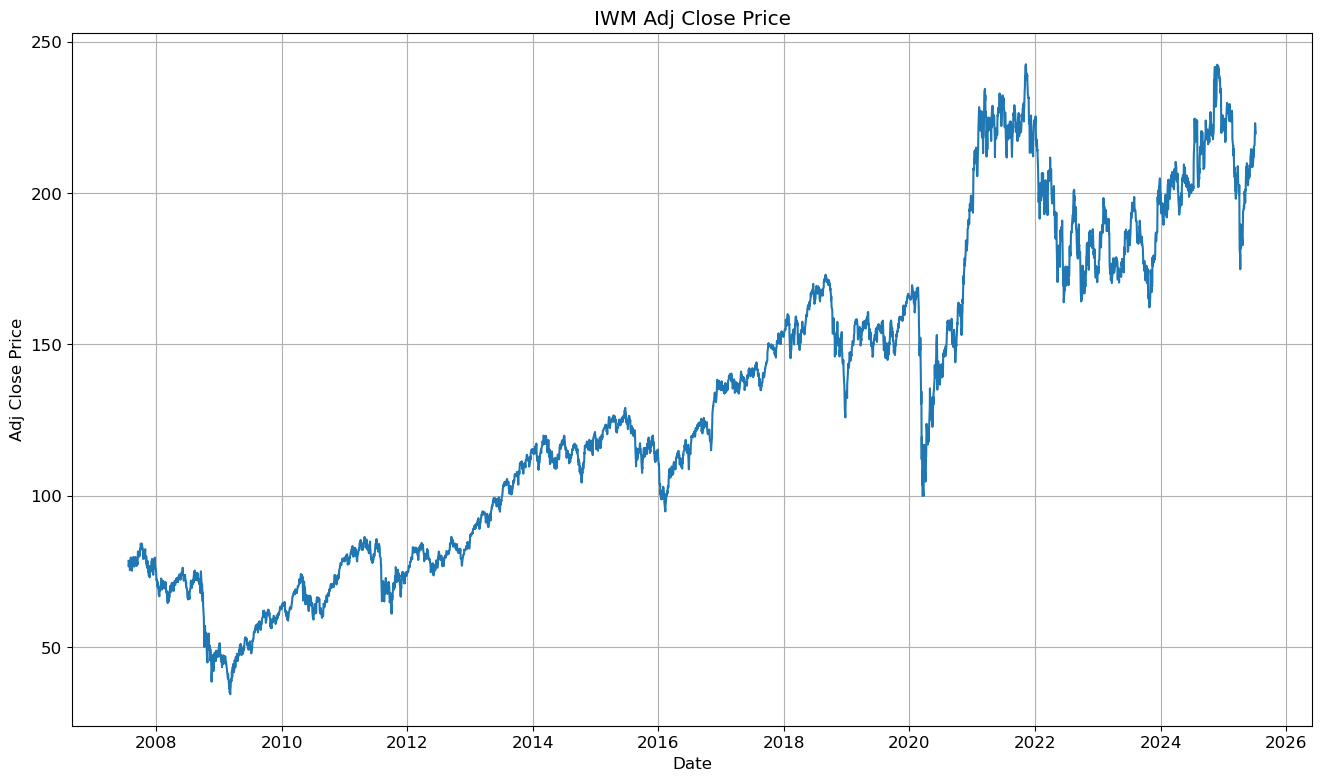

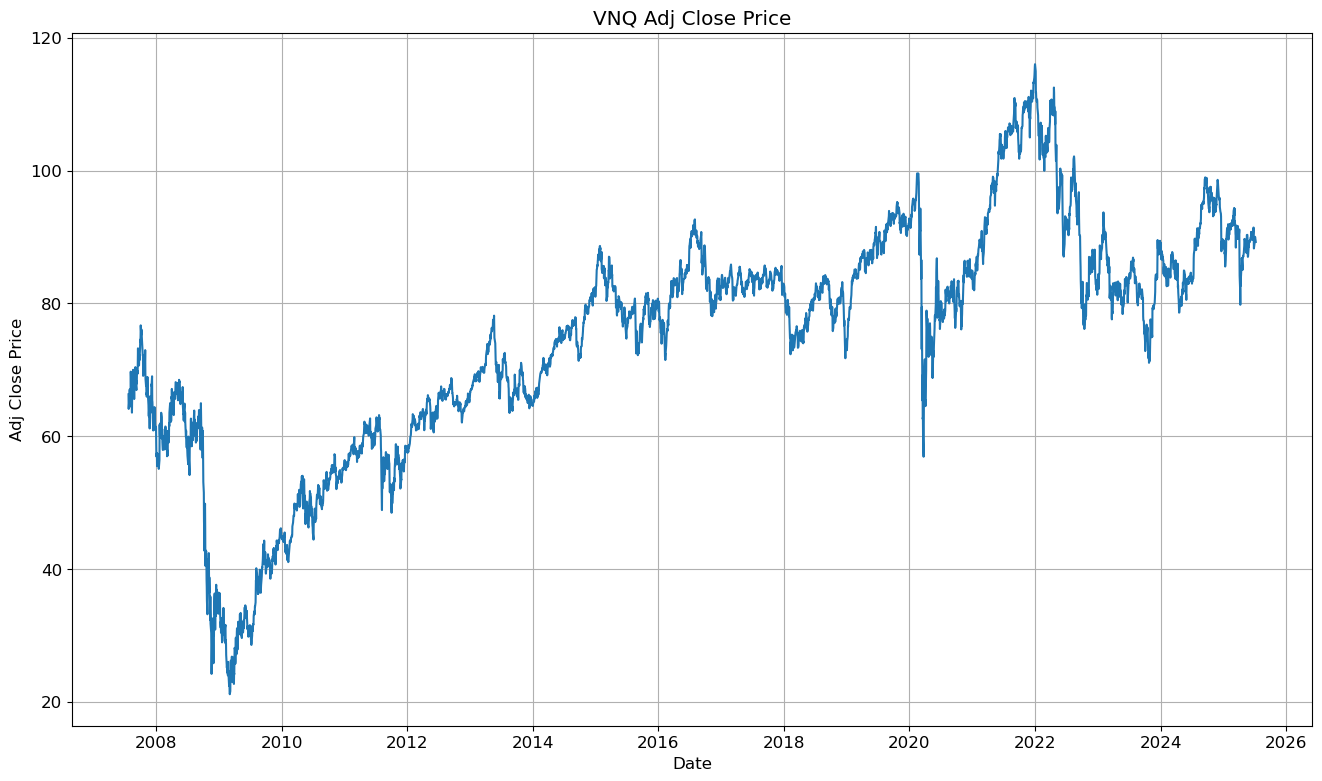

In [19]:
# plotting Adj Close price distribution of random ticker
for rand_ticker in tickers :
    plt.plot(close_prices[rand_ticker].index, close_prices[rand_ticker])
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.title(f'{rand_ticker} Adj Close Price')
    plt.show()

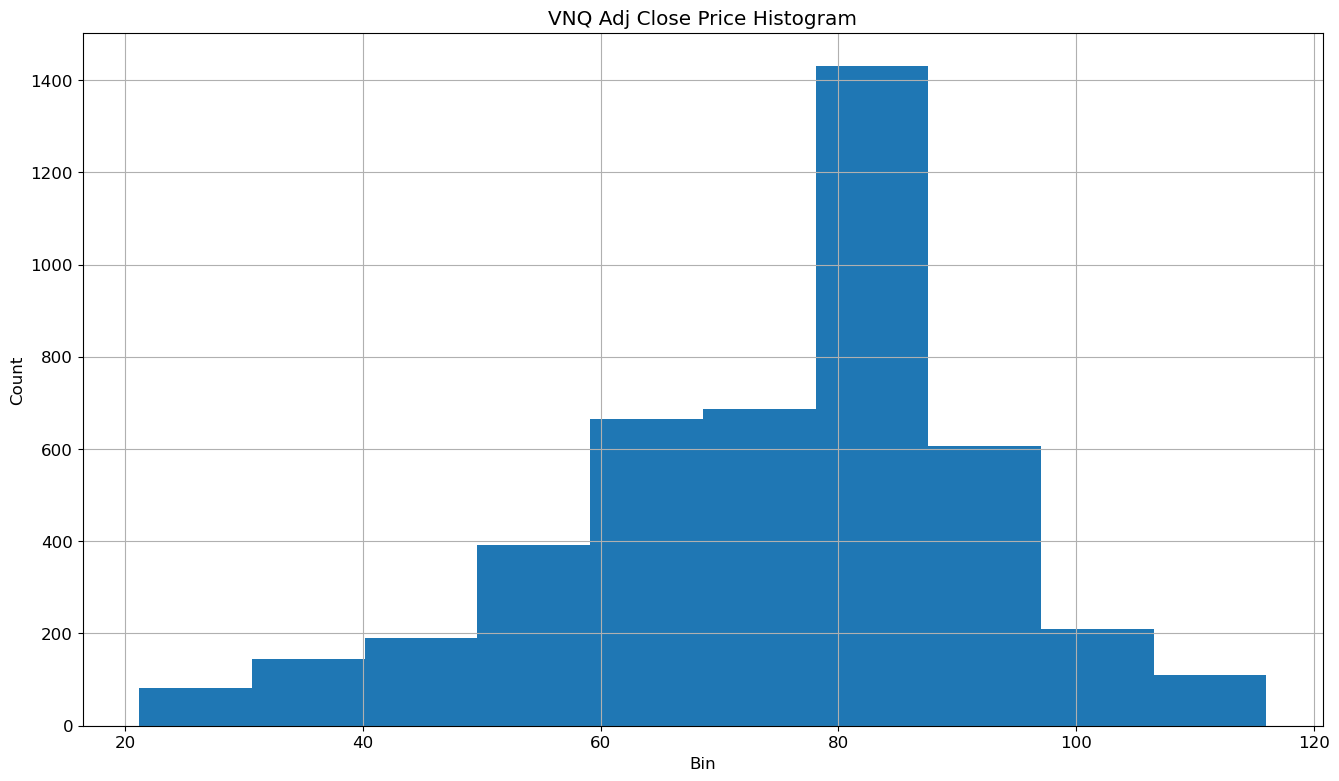

In [20]:
# histogram
plt.hist(close_prices[rand_ticker])
plt.xlabel('Bin')
plt.ylabel('Count')
plt.title(f'{rand_ticker} Adj Close Price Histogram')
plt.show()

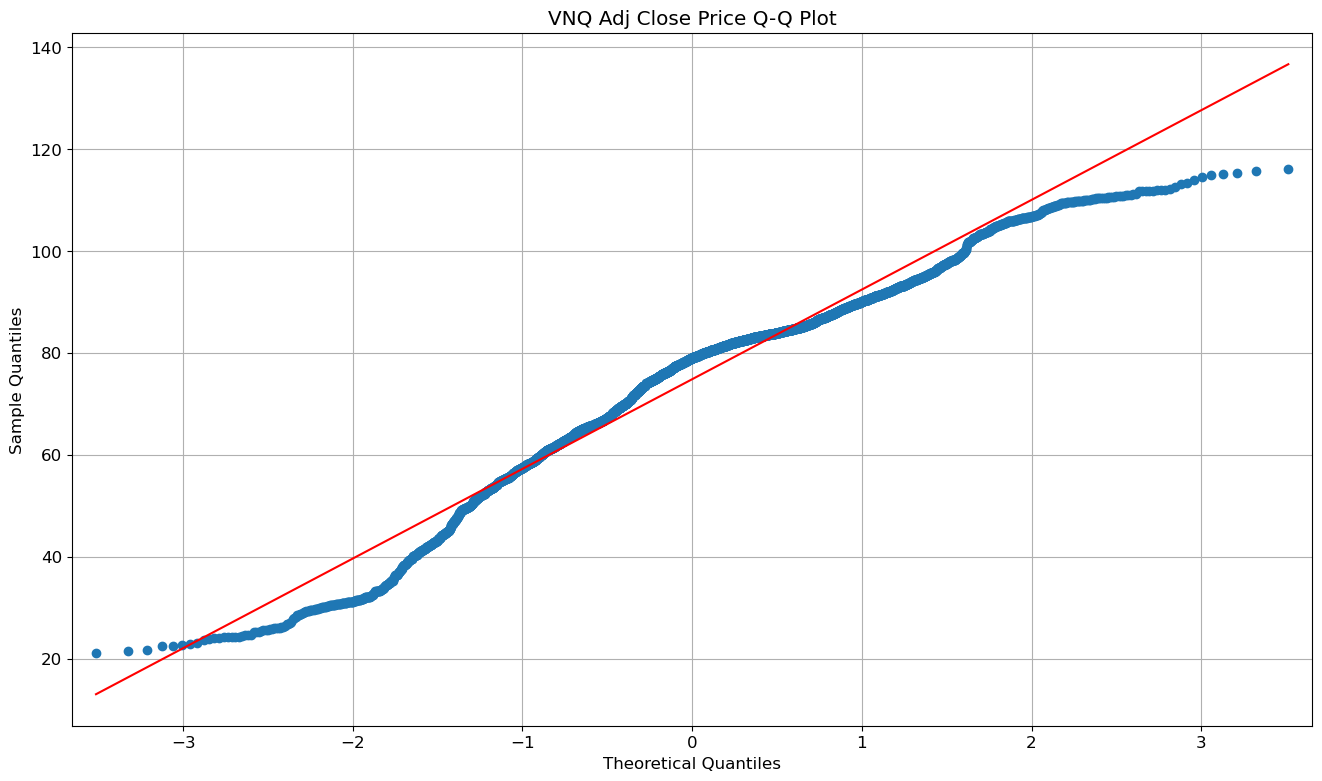

In [21]:
# q-q plot
qqplot(close_prices[rand_ticker], line='s')
plt.title(f'{rand_ticker} Adj Close Price Q-Q Plot')
plt.show()

### 3. Building LSTM model

In [23]:
import torch
print(torch.cuda.is_available())
try:
    print(torch.cuda.get_device_name(0))
except Exception as e:
    print("No GPU device found:", str(e))

True
AMD Radeon RX 7600S


In [62]:
# selecting gpu
device = torch.device('cpu')

In [64]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size # number of features
        self.hidden_size = hidden_size # number of features in hidden state
        self.num_layers = num_layers # number of stacked LSTM layers
        self.num_classes = num_classes # number of output classes
    
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_size, num_classes) # fully connected last layer

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # hidden state
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), 
                                  self.hidden_size)).to(device) # internal state
        # propagating input through LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (seq_length, batch_size, hidden_size)
        # decoding hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [66]:
# function for building model
def build_model(input_size=1, hidden_size=1, num_layers=1, num_classes=1, learning_rate=0.001):
    # learning rate controls how much to change model in response to estm error 
    # each time model weights are updated
    
    model = LSTM_model(input_size, hidden_size, num_layers, num_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # adam optimizer
    # algorithms/methods to change attributes of neural network such as weights and learning rate to reduce losses

    loss_function = torch.nn.MSELoss() # mean-squared error of regression
    # loss function measures how bad model performs: high loss -> low accuracy

    # loading model state
    # model = LSTM_model(*args, **kwargs)
    # model.load_state_dict(torch.load(PATH))
    # model.eval()

    return model, optimizer, loss_function

### 4. Model fitting and evaluation

In [69]:
all_split = 3611

In [70]:
# scaler for normalizing dataset
scaler = MinMaxScaler()

In [73]:
# function for creating X and y
def create_xy(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [74]:
time_step = 100

In [75]:
# dataframes for model loss, predicted Adj Close price and model performance
model_loss_df = pd.DataFrame(index=[epoch for epoch in range(0, 11000, 1000)], columns=tickers)
pred_adj_close_df = pd.DataFrame(index=df.index[time_step + 1:], columns=tickers)
model_perf_df = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'], columns=tickers)

In [76]:
# functions for model performance evaluation
def MAE(y_true, y_hat):
    return np.mean(np.abs(y_true - y_hat))

def MSE(y_true, y_hat):
    return np.mean(np.square(y_true - y_hat))

def RMSE(y_true, y_hat):
    return np.sqrt(MSE(y_true, y_hat))

def MAPE(y_true, y_hat):
    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def MPE(y_true, y_hat):
    return np.mean((y_true - y_hat) / y_true) * 100

In [81]:
# function for fitting model
def fit_model(ticker, X_train, y_train):
    model, optimizer, loss_function = build_model()
    num_epochs = 10000
    
    loss_list = []

    for epoch in range(num_epochs + 1):
        outputs = model.forward(X_train.to(device)) # forward pass
        optimizer.zero_grad() # calculating gradient, manually setting to 0
        loss = loss_function(outputs, y_train.to(device)) # obtaining loss
        loss.backward() # calculating loss of loss function
        optimizer.step() # improving from loss, i.e. backprop
        
        if epoch % 1000 == 0:
            loss_list.append(loss.item())
    
    model_loss_df[ticker] = loss_list

    # saving model state
    torch.save(model.state_dict(), f'model-states/{ticker}-model-state.pth')
    
    return model

In [83]:
import os
import pandas as pd

os.makedirs('model-states', exist_ok=True)

results = []  # Liste pour stocker chaque DataFrame de prédiction individuelle

for ticker in tickers:
    print('----------')
    print(f'{ticker} fitting...')
    print(f'{len(tickers) - (tickers.index(ticker) + 1)} left')

    # Normalisation de la série de prix
    norm_act_adj_close = scaler.fit_transform(np.array(close_prices[ticker]).reshape(-1, 1))

    # Split train/val
    train_set = norm_act_adj_close[:all_split]
    # val_set = norm_act_adj_close[all_split:]  # (optionnel, pas utilisé directement)

    # Séquences rolling window
    X_train, y_train = create_xy(train_set, time_step)
    X_val, y_val = create_xy(norm_act_adj_close, time_step)  # attention : ici val = toute la série, prédit hors sample

    # Conversion en tenseurs
    X_train_tensors = Variable(torch.Tensor(X_train))
    y_train_tensors = Variable(torch.Tensor(y_train))
    X_val_tensors = Variable(torch.Tensor(X_val))

    # Fitting du modèle
    model = fit_model(ticker=ticker, X_train=X_train_tensors, y_train=y_train_tensors)

    # Prédiction sur toute la série (val), désanormalisation
    y_hat = model(X_val_tensors.to(device))
    y_hat = y_hat.data.detach().cpu().numpy()
    y_hat = scaler.inverse_transform(y_hat)

    y_true = scaler.inverse_transform(y_val)

    print('Done!')

    # Dates des prédictions (window oblige, on perd les premiers time_step+1 jours)
    pred_index = close_prices[ticker].index[time_step+1:time_step+1+len(y_hat)]

    # DataFrame individuel pour ce ticker
    pred_df = pd.DataFrame(y_hat.flatten(), index=pred_index, columns=[ticker])
    results.append(pred_df)

    # Calcul et stockage des performances
    model_perf_df[ticker] = [MAE(y_true, y_hat), MSE(y_true, y_hat), RMSE(y_true, y_hat), 
                             MAPE(y_true, y_hat), MPE(y_true, y_hat)]

# Fusion de toutes les prédictions en un seul DataFrame multi-actifs (alignement automatique sur les dates existantes)
pred_adj_close_df = pd.concat(results, axis=1)

# Visualisation rapide (pour vérifier)
print(pred_adj_close_df.tail())
print(model_perf_df)


----------
SPY fitting...
6 left
Done!
----------
QQQ fitting...
5 left
Done!
----------
VEA fitting...
4 left
Done!
----------
BND fitting...
3 left
Done!
----------
GLD fitting...
2 left
Done!
----------
IWM fitting...
1 left
Done!
----------
VNQ fitting...
0 left
Done!
                   SPY         QQQ        VEA        BND         GLD  \
date                                                                   
2025-06-30  551.171875  478.611877  55.943886  73.640518  261.657288   
2025-07-01  552.383179  479.104462  56.290787  73.575768  260.026398   
2025-07-02  553.588013  479.617828  56.513420  73.741219  261.099121   
2025-07-03  554.105103  479.901398  56.556244  73.603951  261.861237   
2025-07-07  555.142517  480.242645  56.667503  73.503349  262.323669   

                   IWM        VNQ  
date                               
2025-06-30  215.036240  88.407921  
2025-07-01  215.583252  88.486435  
2025-07-02  215.982162  89.053093  
2025-07-03  217.761108  89.712067  
2025-0

### 5. Results

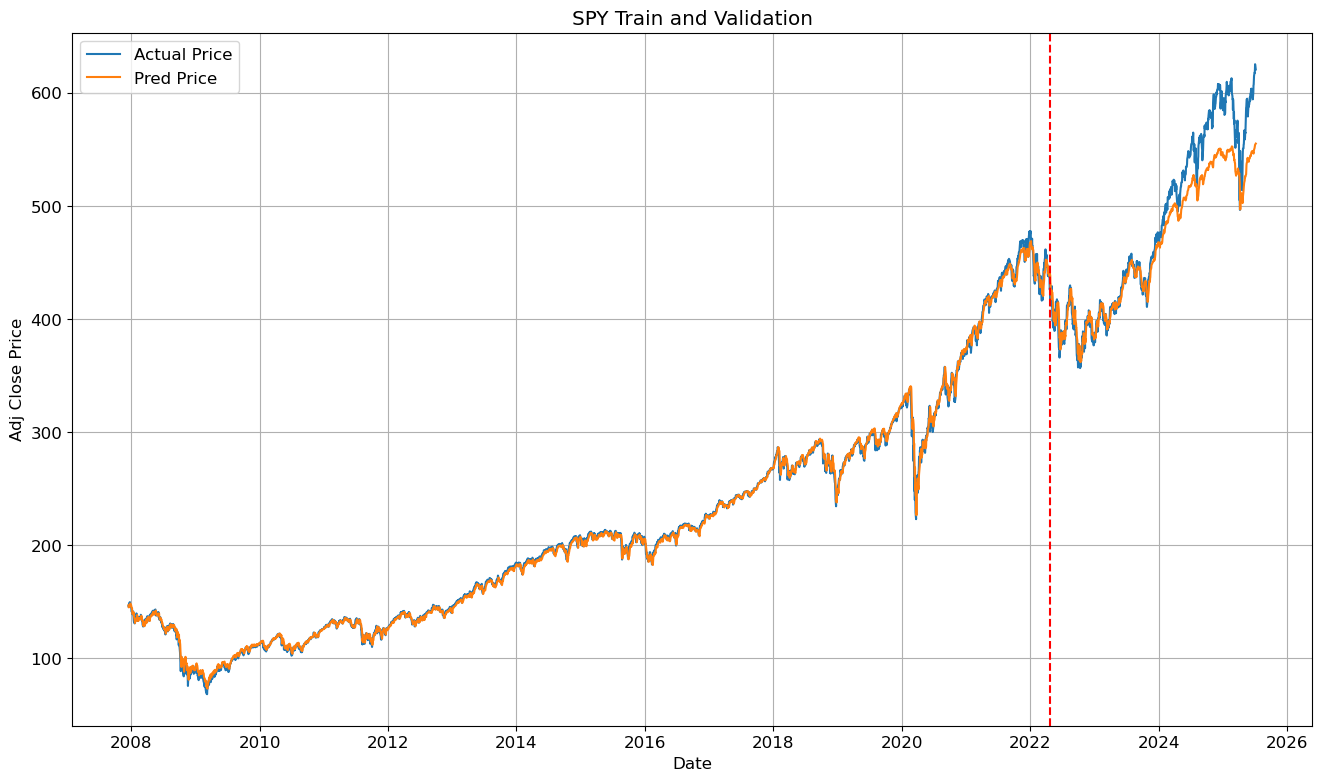

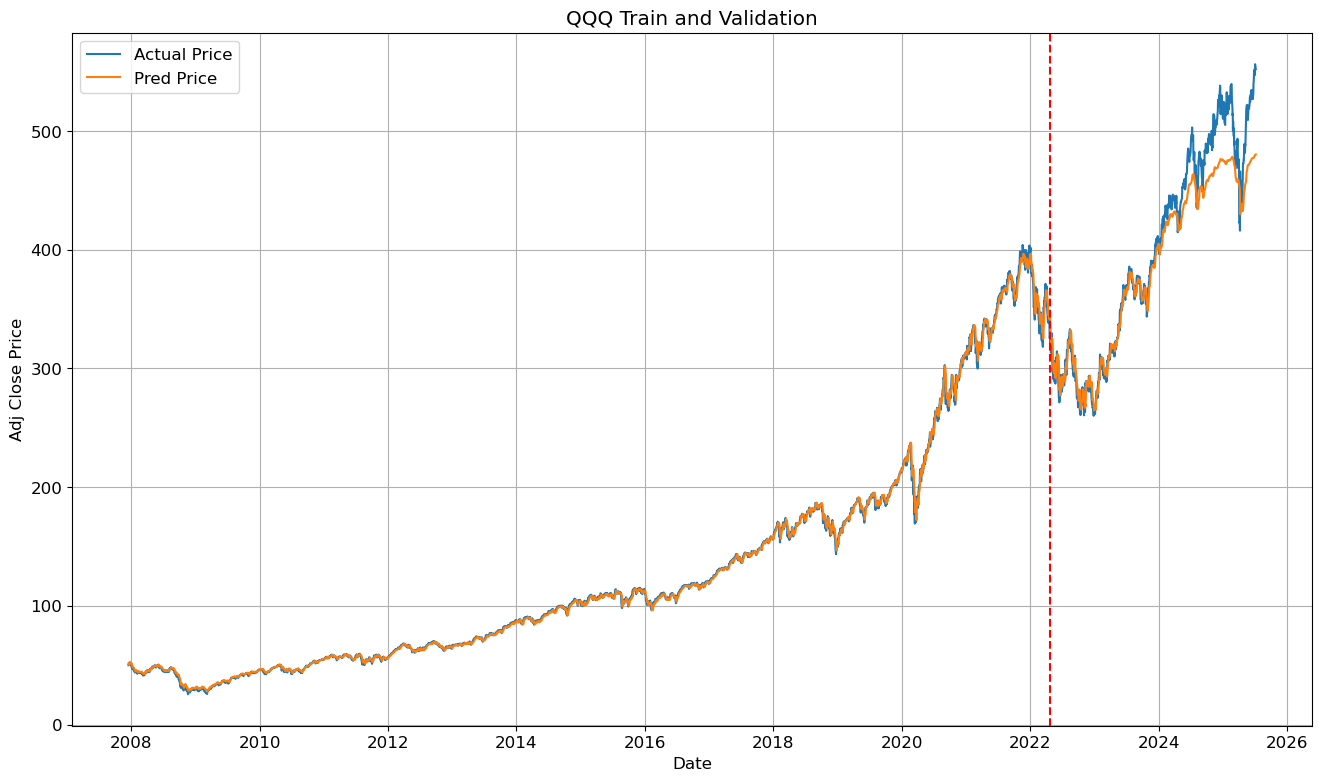

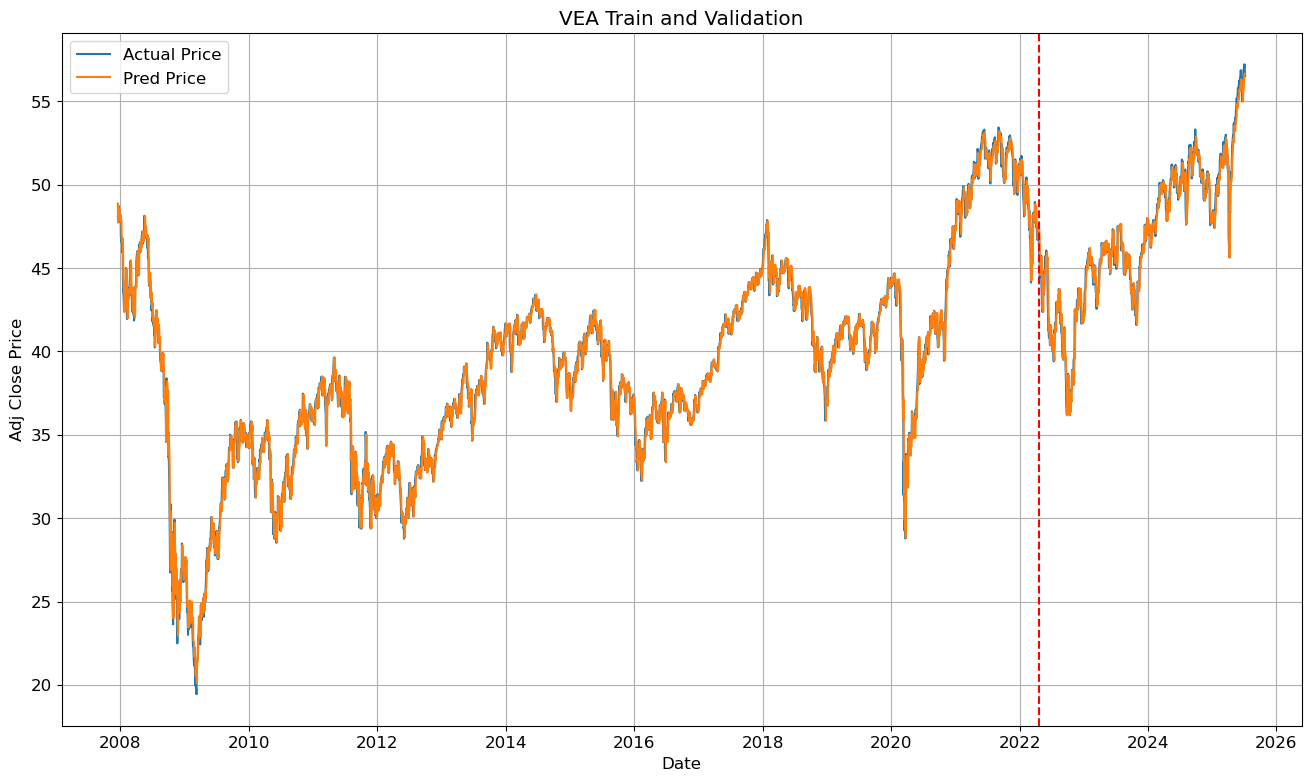

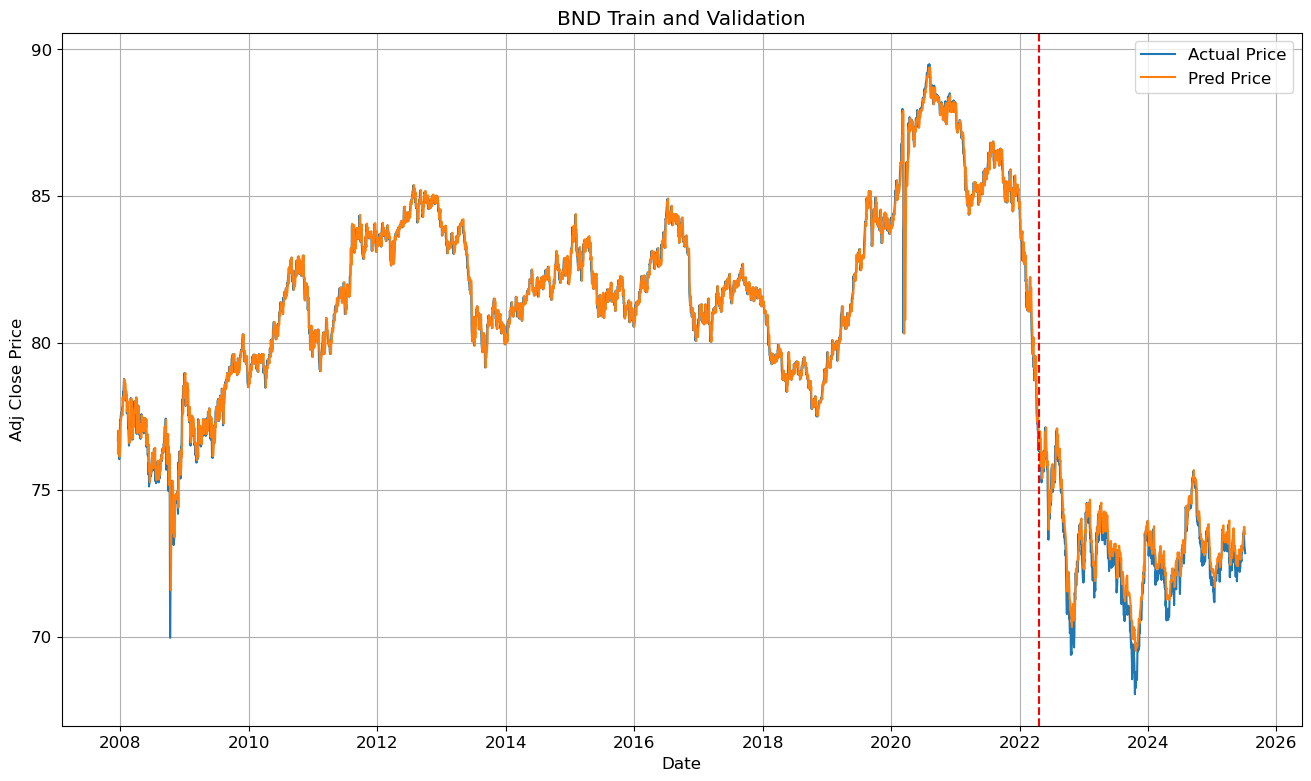

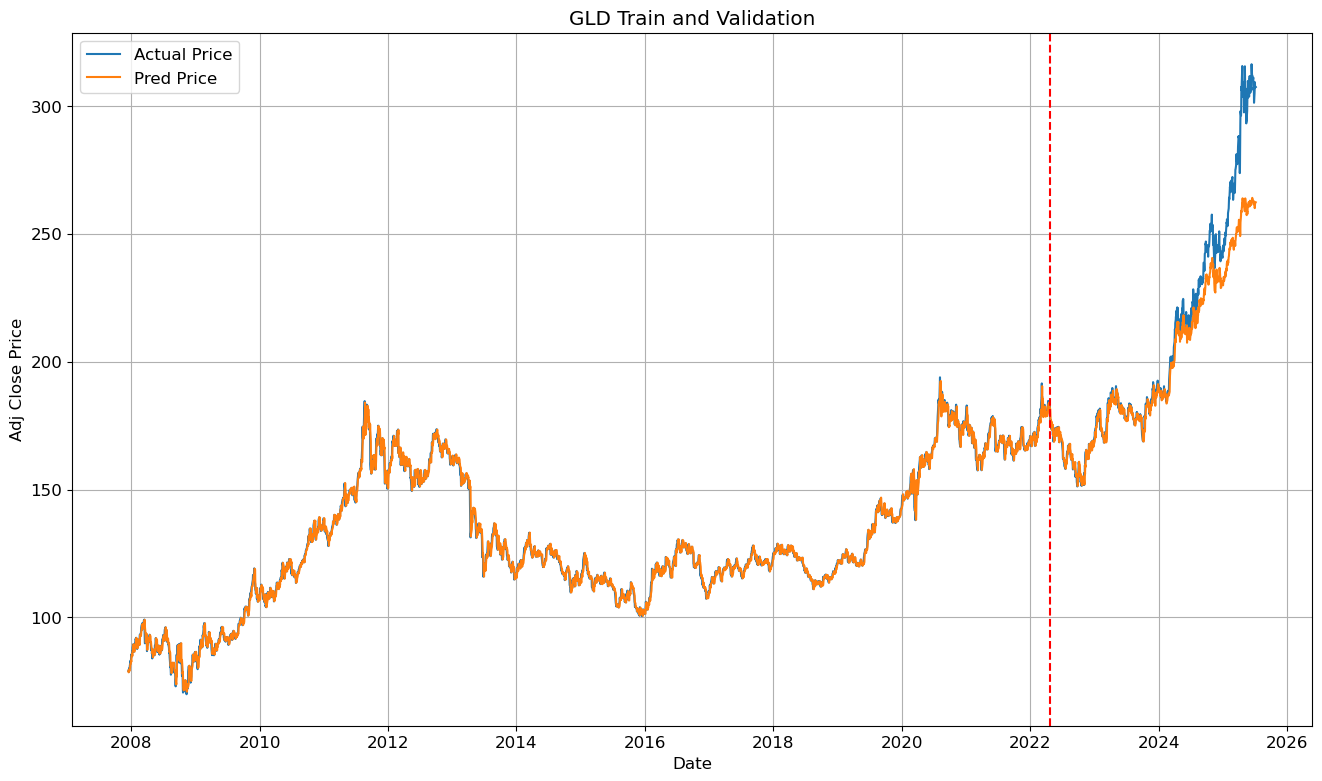

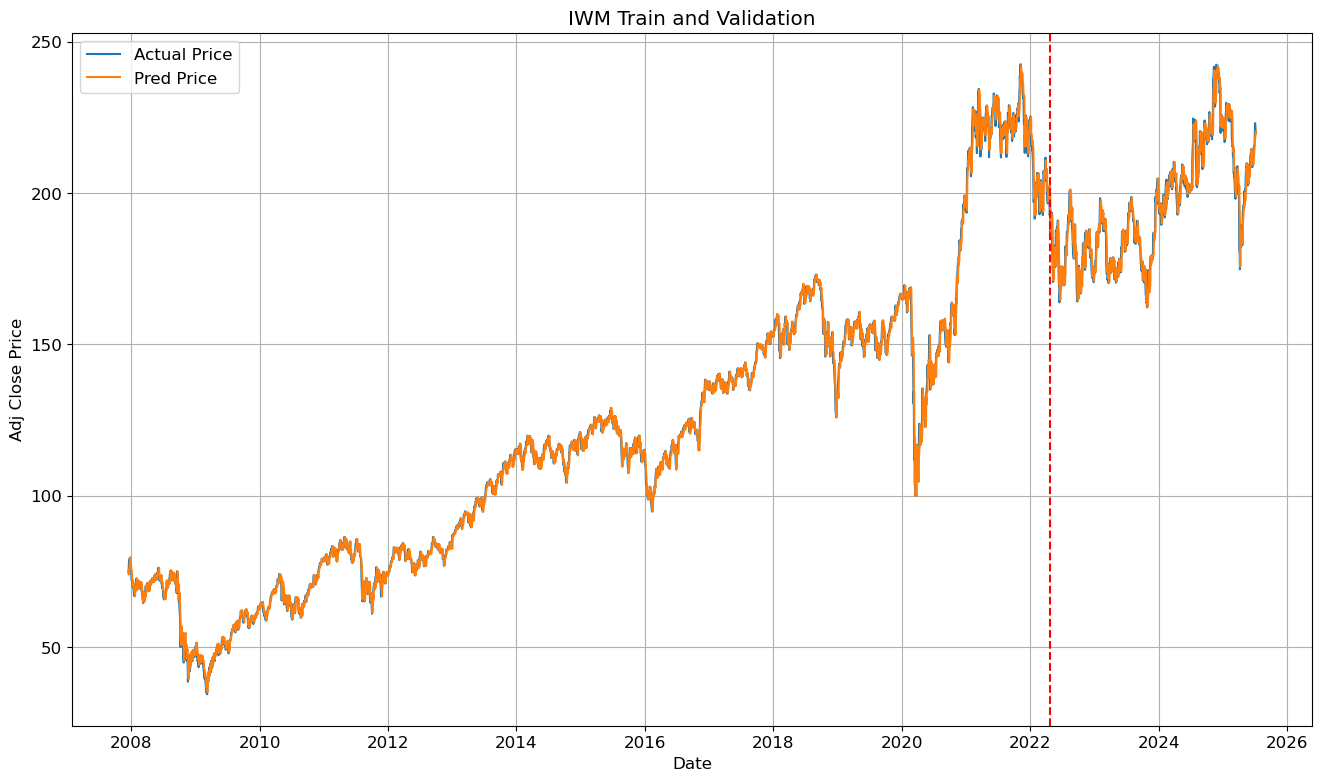

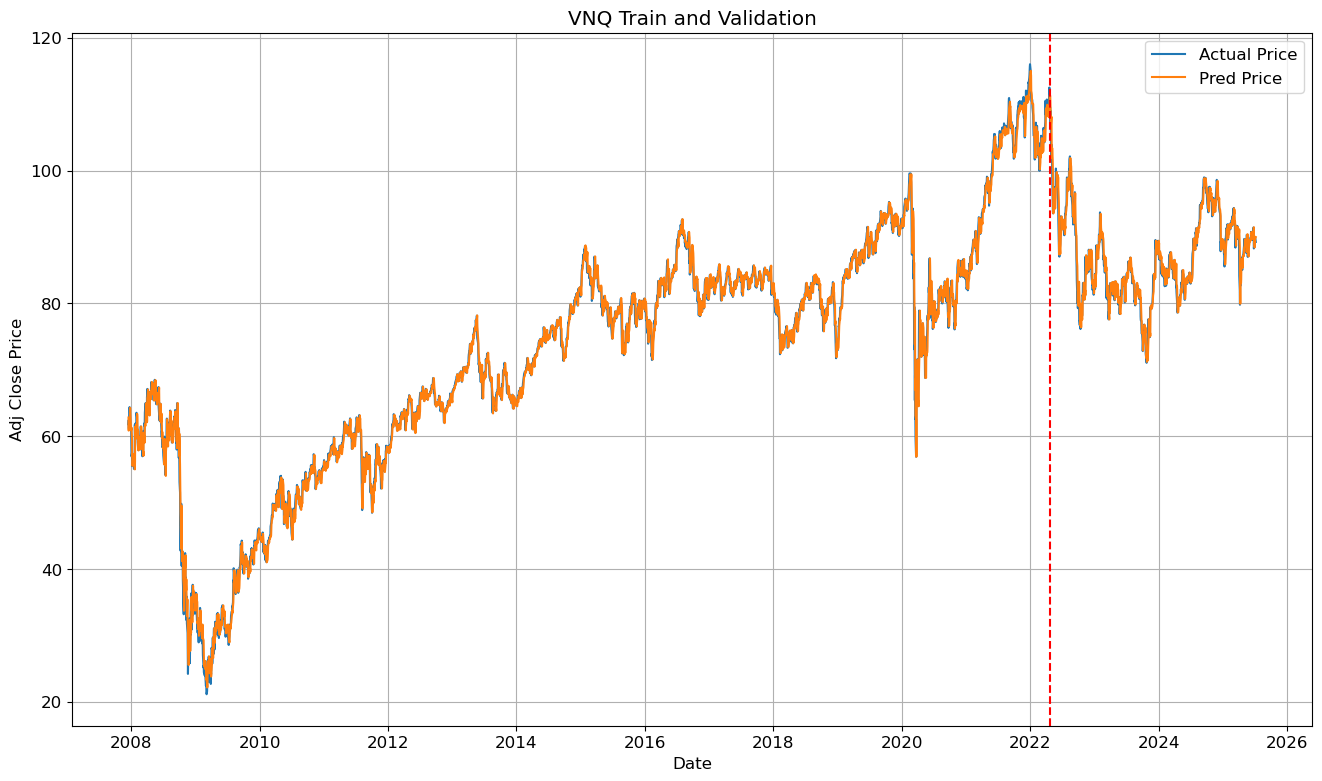

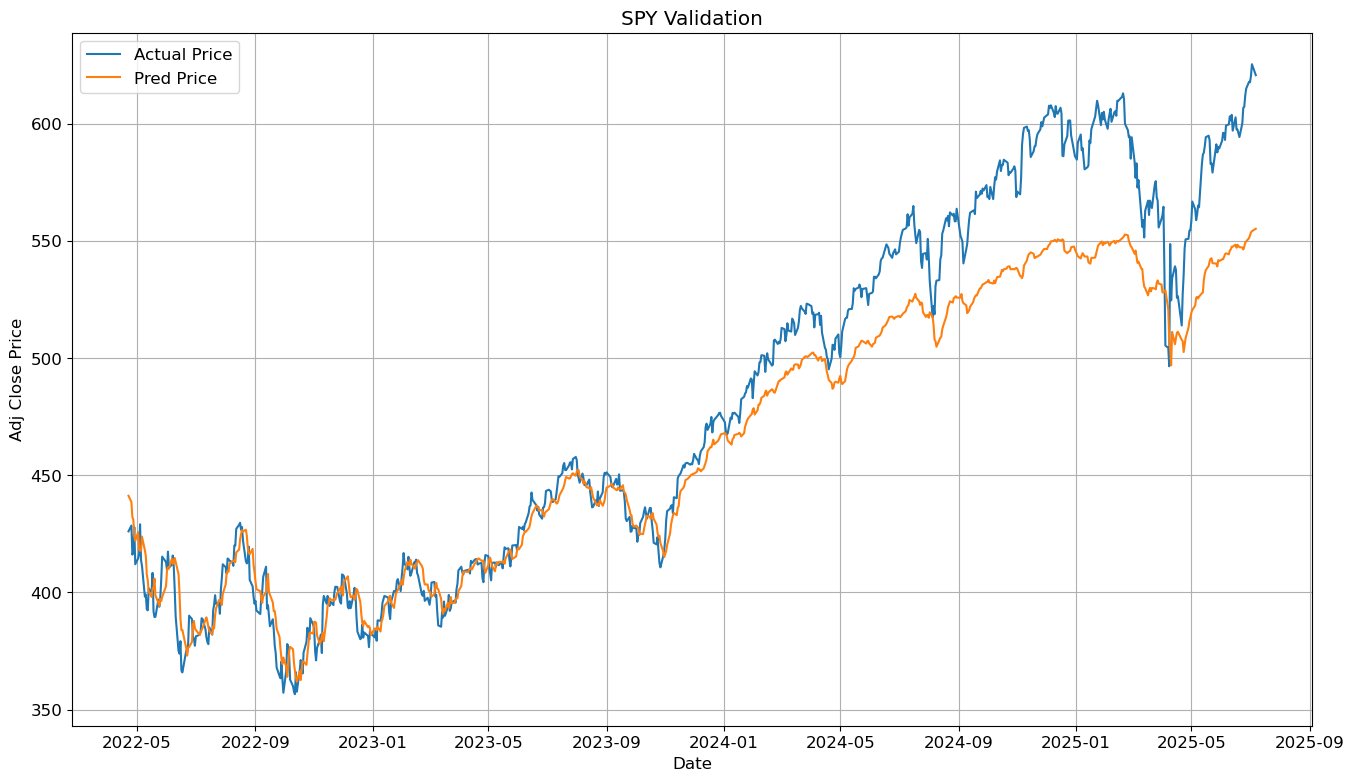

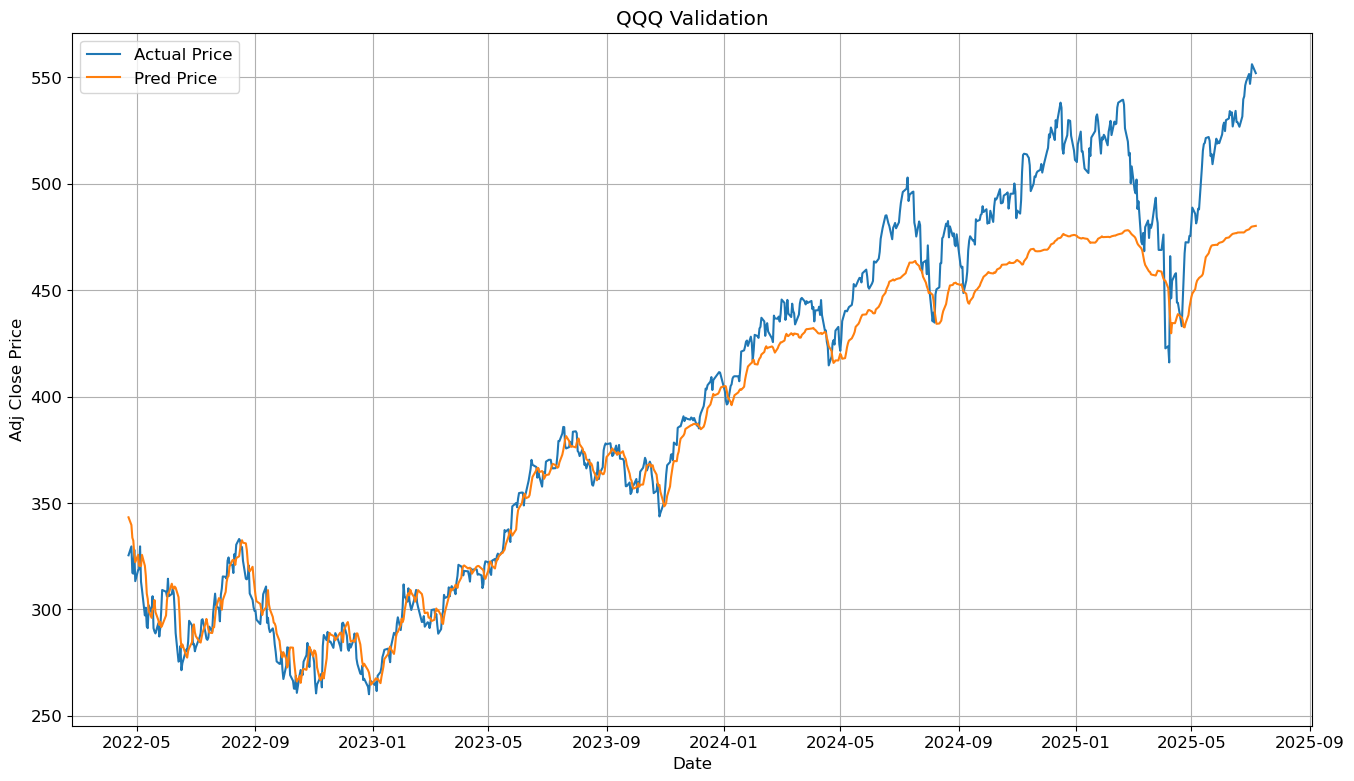

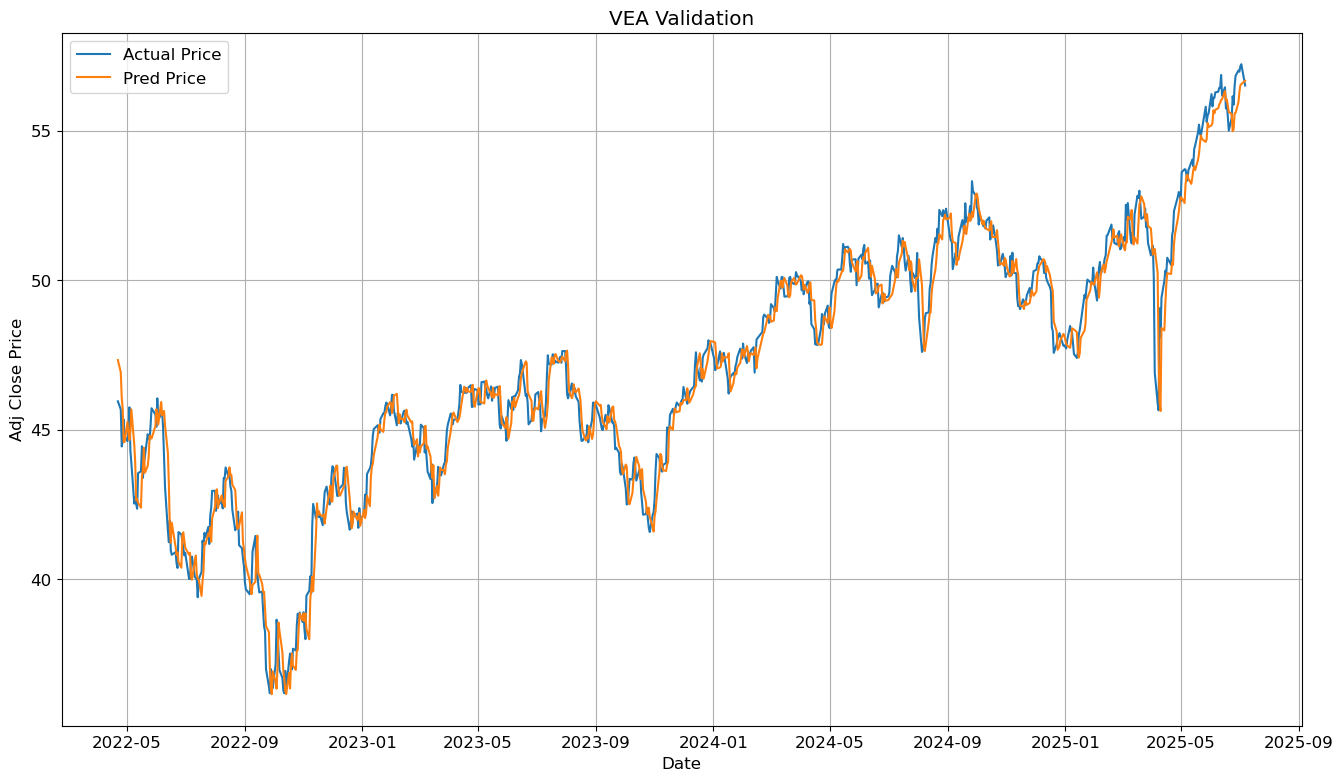

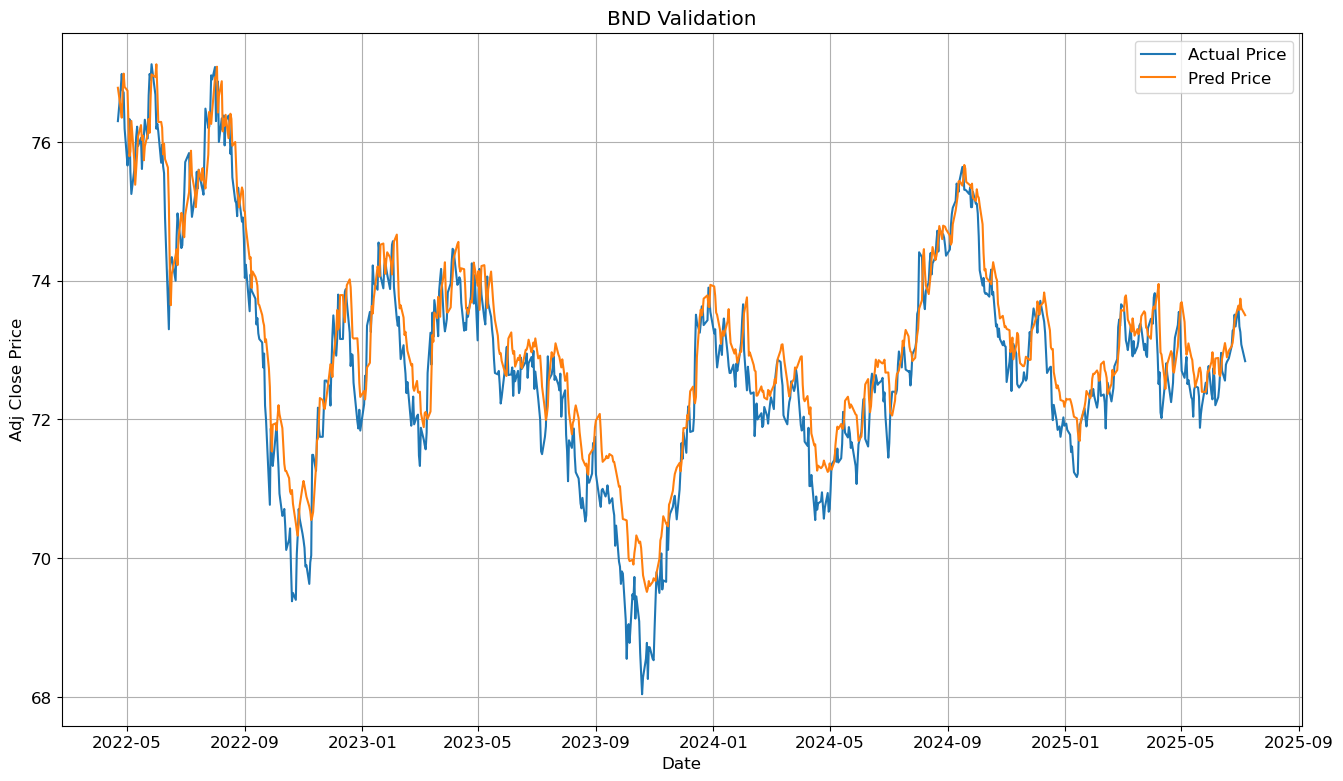

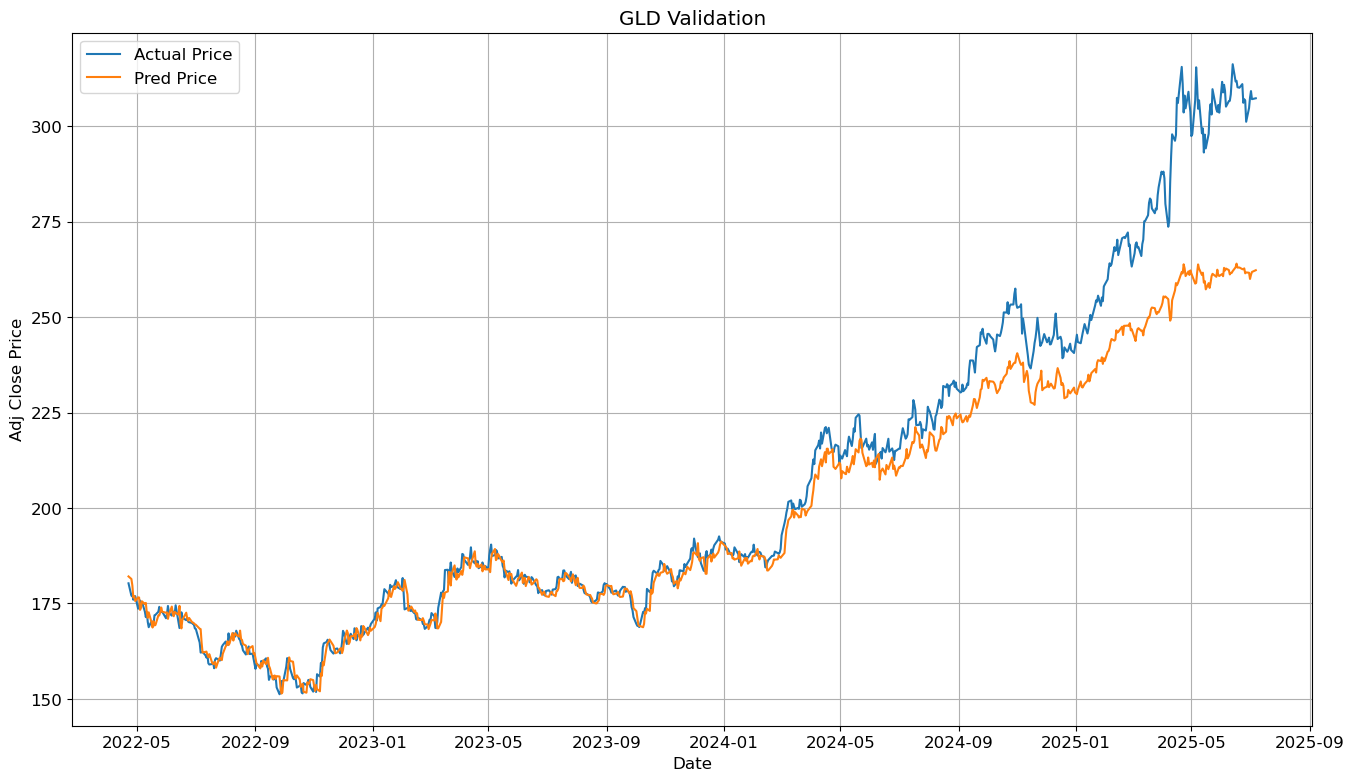

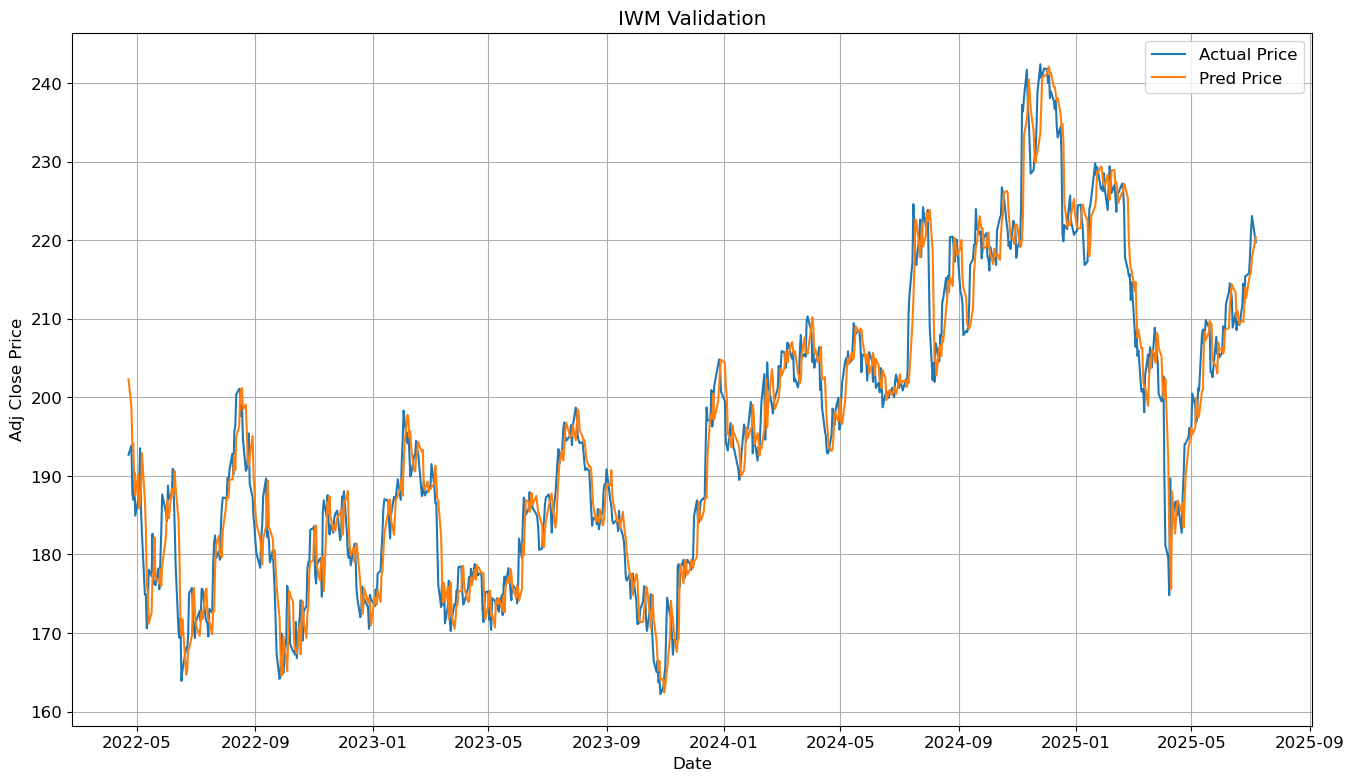

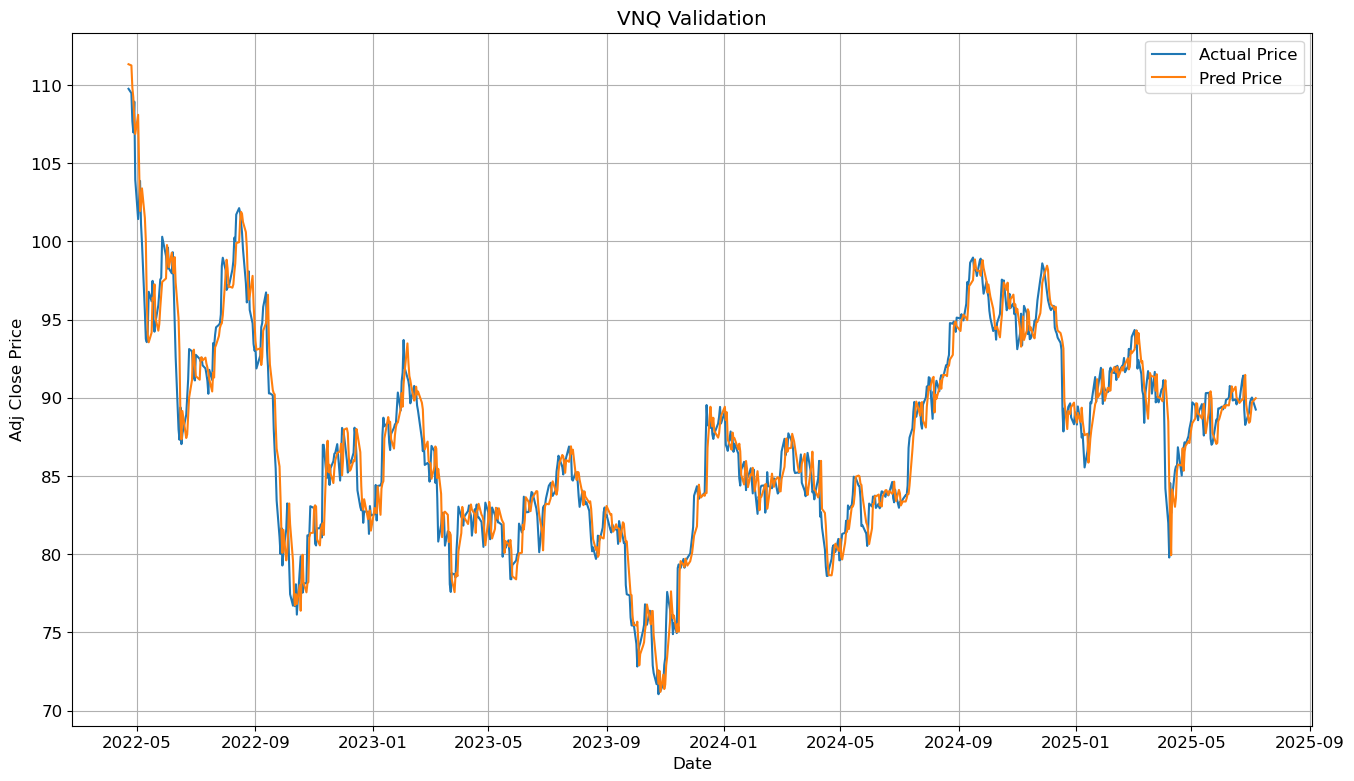

In [94]:
# plotting actual and predicted Adj Close price of random ticker
for ticker in tickers:
    plt.plot(pred_adj_close_df.index, close_prices[ticker][time_step + 1:], label='Actual Price')
    plt.plot(pred_adj_close_df.index, pred_adj_close_df[ticker], label='Pred Price')
    plt.axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.title(f'{ticker} Train and Validation')
    plt.legend()
    plt.show() 
for ticker in tickers :
    val_act = close_prices[ticker][time_step + 1 + all_split:]
    val_pred = pred_adj_close_df[ticker][all_split:]

    plt.plot(pred_adj_close_df.index[all_split:], val_act, label='Actual Price')
    plt.plot(pred_adj_close_df.index[all_split:], val_pred, label='Pred Price')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.title(f'{ticker} Validation')
    plt.legend()
    plt.show()
    

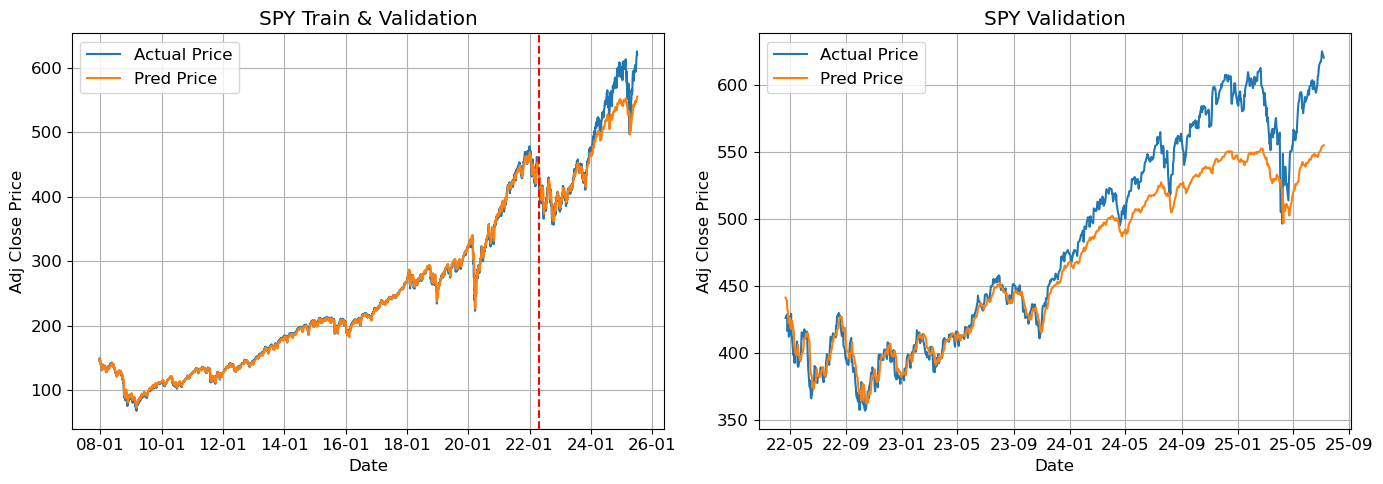

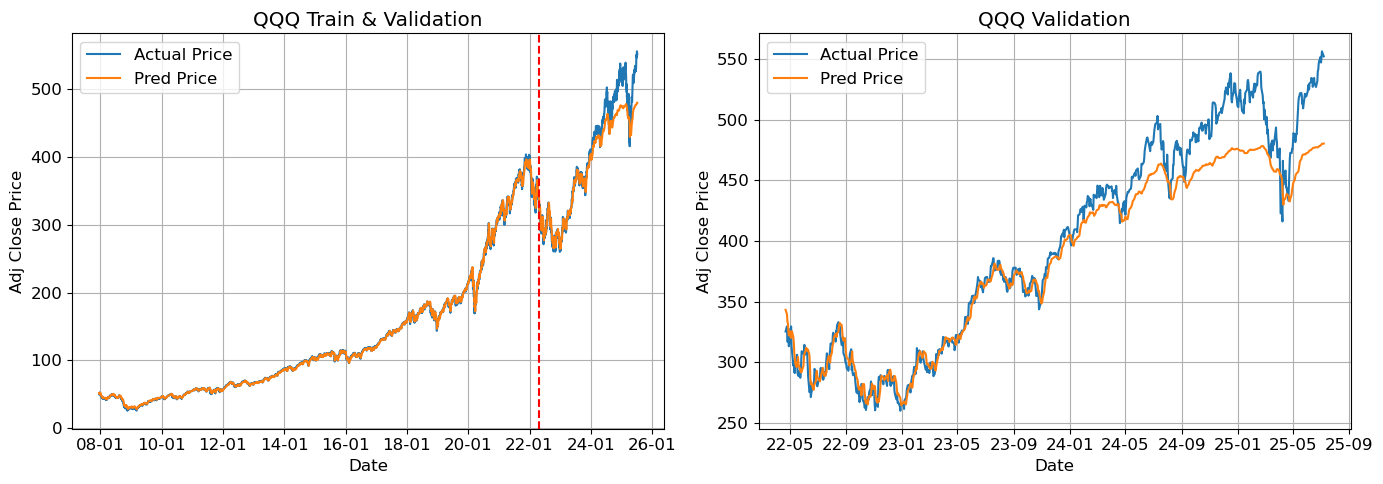

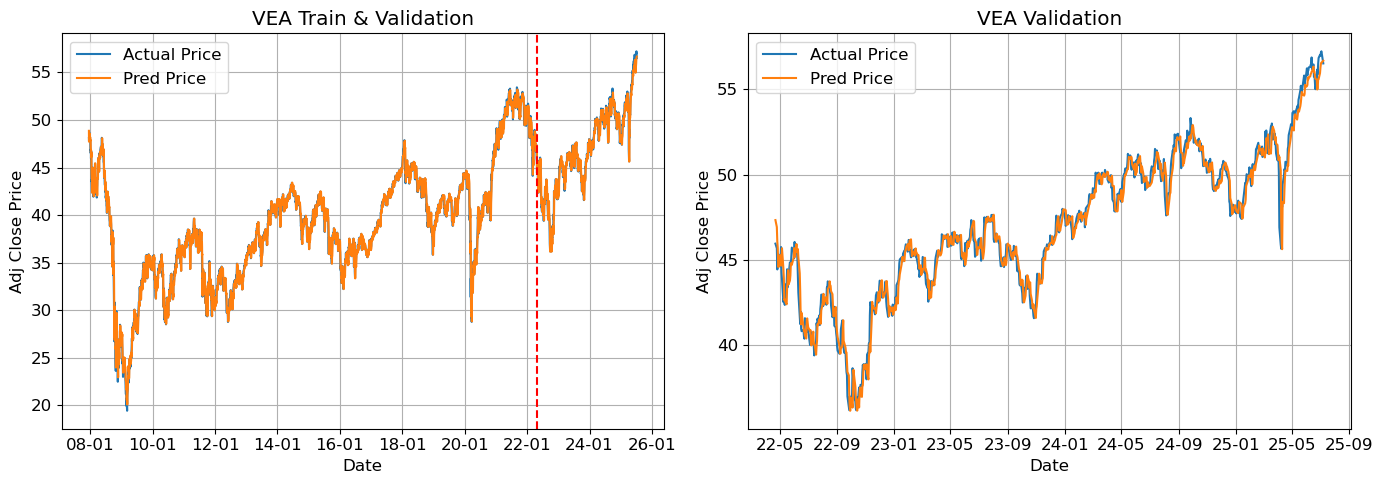

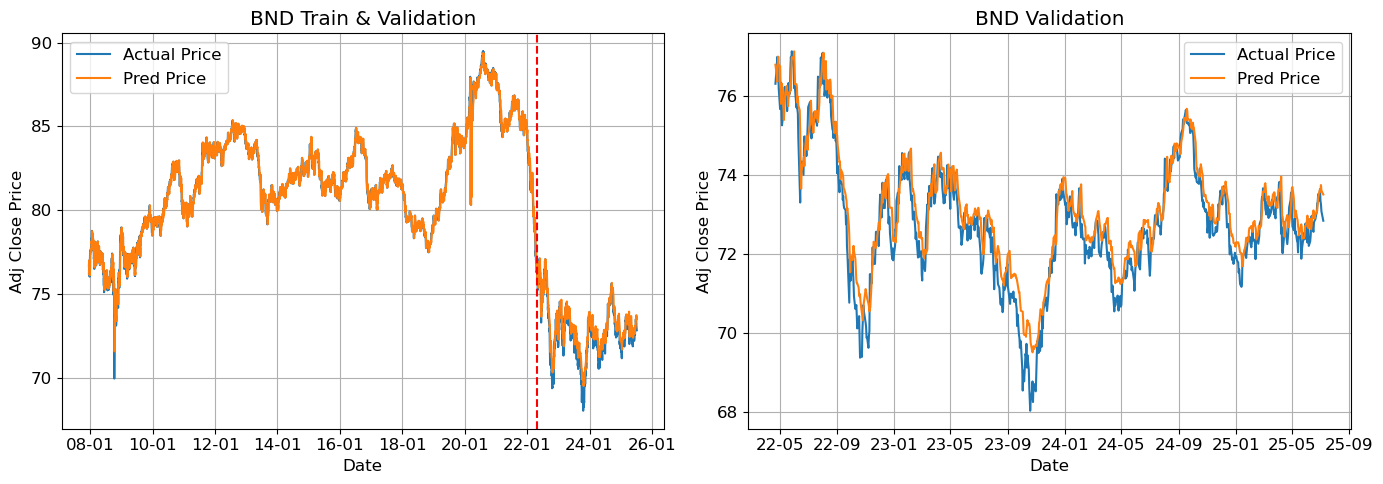

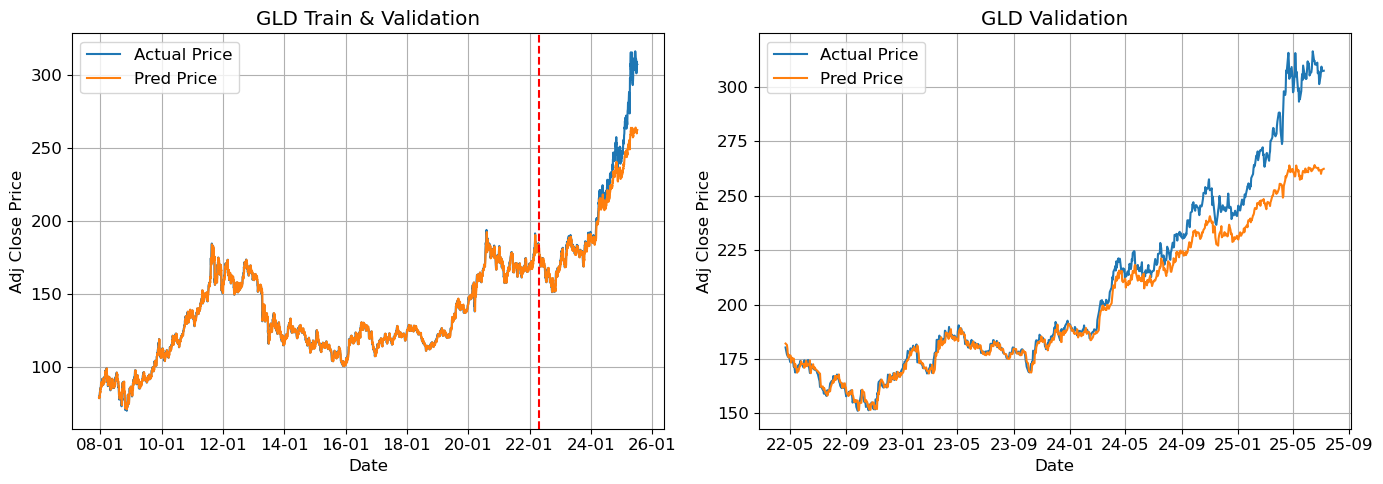

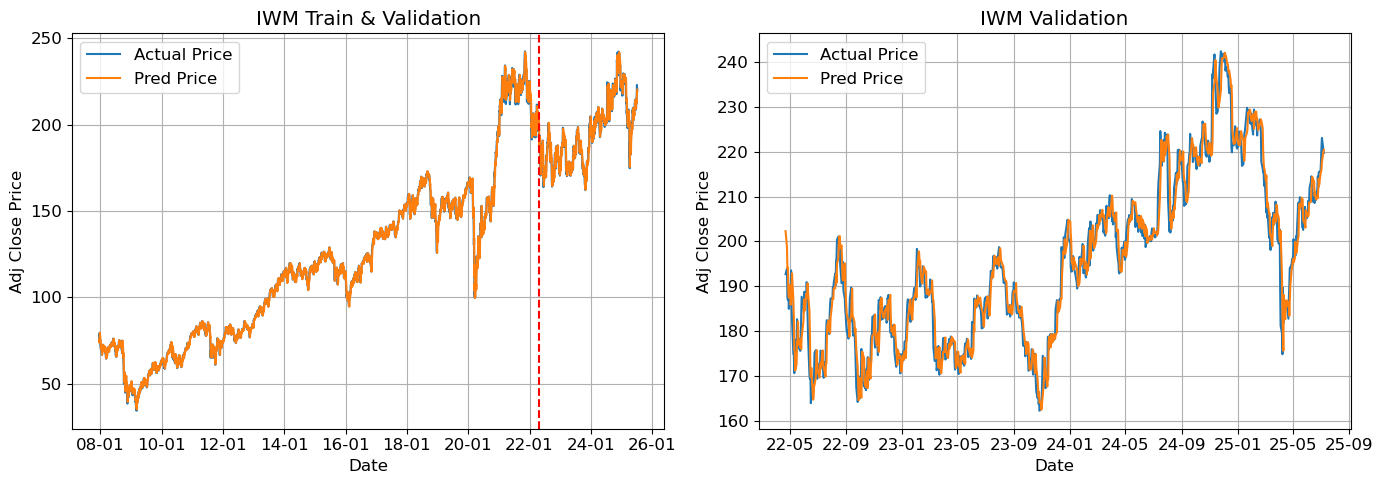

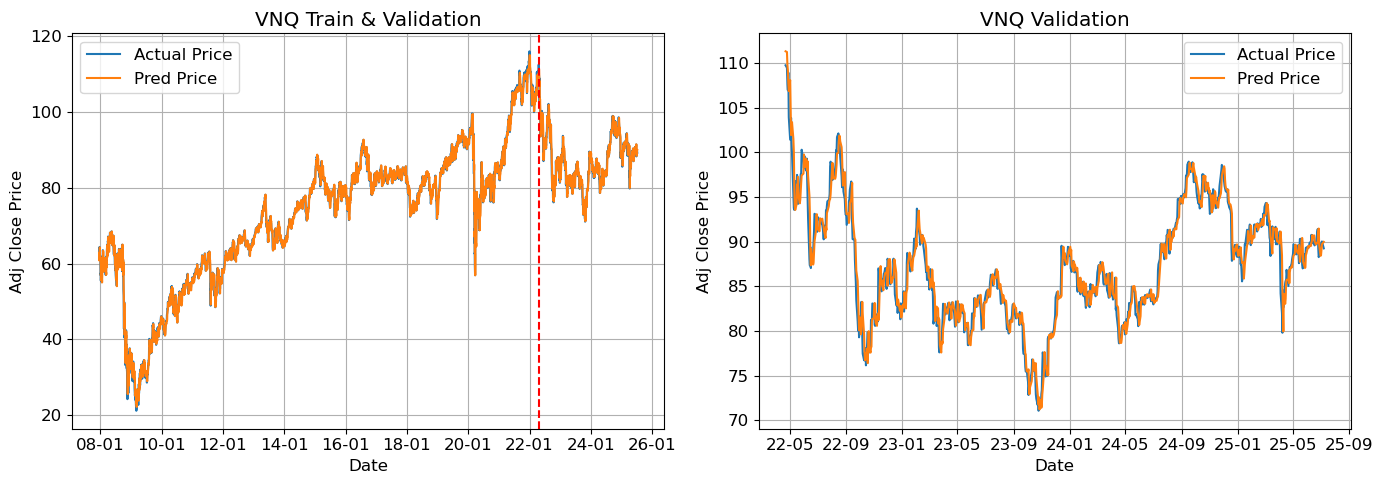

In [167]:
import matplotlib.dates as mdates

for ticker in tickers:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Graphe 1 : Train + Validation ---
    axs[0].plot(pred_adj_close_df.index, close_prices[ticker][time_step + 1:], label='Actual Price')
    axs[0].plot(pred_adj_close_df.index, pred_adj_close_df[ticker], label='Pred Price')
    axs[0].axvline(x=pred_adj_close_df.index[all_split], c='r', linestyle='--')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Adj Close Price')
    axs[0].set_title(f'{ticker} Train & Validation')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))  # <-- Ici

    # --- Graphe 2 : Validation seule, alignement des dates ---
    val_dates = pred_adj_close_df.index[all_split:]
    val_act = pd.Series(
        close_prices[ticker][time_step + 1 + all_split:],
        index=val_dates
    )
    val_pred = pred_adj_close_df[ticker][all_split:]

    axs[1].plot(val_dates, val_act, label='Actual Price')
    axs[1].plot(val_dates, val_pred, label='Pred Price')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Adj Close Price')
    axs[1].set_title(f'{ticker} Validation')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))  # <-- Ici

    plt.tight_layout()
    plt.show()


In [96]:
print(f'Val RMSE: {mean_squared_error(val_act, val_pred, squared=True)}')

Val RMSE: 2.648046204777586


/home/ilyesghorbel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [100]:
model_loss_df.tail()

SPY       QQQ       VEA       BND       GLD       IWM       VNQ
6000   0.000036  0.000037  0.000176  0.000152  0.000037  0.000087  0.000144
7000   0.000034  0.000028  0.000173  0.000143  0.000034  0.000075  0.000132
8000   0.000032  0.000023  0.000171  0.000138  0.000033  0.000068  0.000128
9000   0.000030  0.000020  0.000169  0.000137  0.000032  0.000066  0.000127
10000  0.000027  0.000017  0.000168  0.000137  0.000032  0.000065  0.000126

In [102]:
print(pred_adj_close_df)

                   SPY         QQQ        VEA        BND         GLD  \
date                                                                   
2007-12-18  146.819046   51.575535  48.861683  76.231613   78.914536   
2007-12-19  145.007156   50.887531  47.722198  76.483742   78.567726   
2007-12-20  145.136490   50.601185  47.979282  76.679680   79.490395   
2007-12-21  145.085770   50.431309  47.832890  76.982109   79.589806   
2007-12-24  145.717926   50.740231  47.918716  77.022758   79.107590   
...                ...         ...        ...        ...         ...   
2025-06-30  551.171875  478.611877  55.943886  73.640518  261.657288   
2025-07-01  552.383179  479.104462  56.290787  73.575768  260.026398   
2025-07-02  553.588013  479.617828  56.513420  73.741219  261.099121   
2025-07-03  554.105103  479.901398  56.556244  73.603951  261.861237   
2025-07-07  555.142517  480.242645  56.667503  73.503349  262.323669   

                   IWM        VNQ  
date                       

In [104]:
model_perf_df

SPY        QQQ       VEA       BND        GLD       IWM       VNQ
MAE     5.034851   4.047606  0.346981  0.202199   2.238893  1.384742  0.751594
MSE   130.033182  99.405442  0.244206  0.094156  39.695267  4.081412  1.183729
RMSE   11.403209   9.970228  0.494172  0.306848   6.300418  2.020250  1.087993
MAPE    1.491437   1.663228  0.912612  0.259930   1.191683  1.114155  1.143804
MPE     0.425946   0.283978 -0.007388 -0.085035   0.496411 -0.068433 -0.047964

In [171]:
from IPython.display import display, HTML

# Tableaux arrondis pour l'affichage
naive_perf_df = naive_perf_df.astype(float).round(3)
model_perf_df = model_perf_df.astype(float).round(3)

display(HTML(naive_perf_df.style.set_caption("Performance du modèle naïf (persistance)")
             .set_table_styles([{"selector":"caption","props":[("text-align","left"), ("font-weight","bold")]}])
             .background_gradient(cmap="Blues")
             .format(precision=3)
             .to_html()))

display(HTML(model_perf_df.style.set_caption("Performance du modèle LSTM")
             .set_table_styles([{"selector":"caption","props":[("text-align","left"), ("font-weight","bold")]}])
             .background_gradient(cmap="Greens")
             .format(precision=3)
             .to_html()))


### 6. Building portfolios

In [109]:
# === Rendements journaliers des prix réels Adj Close (phase de Train uniquement) ===

act_adj_close_train_df = close_prices.iloc[:all_split + time_step +2 , :]
act_daily_ret_train_df = act_adj_close_train_df.pct_change()
act_daily_ret_train_df = act_daily_ret_train_df.iloc[1:, :]  # On retire la 1re ligne qui devient NaN après pct_change()
act_daily_ret_train_df


SPY       QQQ       VEA       BND       GLD       IWM  \
date                                                                     
2007-07-27 -0.019660 -0.020212 -0.014405 -0.000803 -0.003656 -0.023324   
2007-07-30  0.015643  0.011669  0.015886 -0.000938  0.005504  0.017356   
2007-07-31 -0.011263 -0.021009 -0.001251  0.002011  0.000304 -0.011031   
2007-08-01  0.004872  0.007785  0.004175 -0.004550  0.002128  0.005447   
2007-08-02  0.007990  0.009186 -0.002911  0.001748 -0.000607  0.007869   
...              ...       ...       ...       ...       ...       ...   
2022-04-18  0.000411  0.000768 -0.004254 -0.003244  0.003097 -0.006735   
2022-04-19  0.016143  0.022351  0.004486 -0.006249 -0.015113  0.019937   
2022-04-20 -0.000742 -0.014584  0.007444  0.006288  0.004895  0.003820   
2022-04-21 -0.014954 -0.020691 -0.011822 -0.005338 -0.003558 -0.022389   
2022-04-22 -0.027439 -0.026186 -0.018372 -0.001309 -0.009722 -0.025885   

                 VNQ  
date                  
2007-07-27 -0.033177  
2007-07-30  0.019342  
2007-07-31 -0.003979  
2007-08-01  0.013212  
2007-08-02  0.016528  
...              ...  
2022-04-18 -0.004046  
2022-04-19  0.021791  
2022-04-20  0.016628  
2022-04-21 -0.006933  
2022-04-22 -0.017544  

[3712 rows x 7 columns]

In [111]:
# daily returns of actual Adj Close price (validation phase)
act_adj_close_val_df = close_prices.iloc[time_step + 1 + all_split:, :]
act_daily_ret_df = act_adj_close_val_df.pct_change()
act_daily_ret_df = act_daily_ret_df.iloc[1:, :]
act_daily_ret_df

SPY       QQQ       VEA       BND       GLD       IWM  \
date                                                                     
2022-04-25  0.005798  0.012846 -0.005876  0.006291 -0.017971  0.006072   
2022-04-26 -0.028961 -0.037745 -0.027145  0.002605  0.001525 -0.031519   
2022-04-27  0.002812 -0.001198  0.004500 -0.003118 -0.007557 -0.004155   
2022-04-28  0.025259  0.035516  0.015681 -0.000391  0.005398  0.018667   
2022-04-29 -0.036956 -0.044999 -0.012572 -0.006779 -0.000113 -0.028879   
...              ...       ...       ...       ...       ...       ...   
2025-06-30  0.004781  0.006477  0.003167  0.003954  0.011985  0.001439   
2025-07-01 -0.000324 -0.008429 -0.000702 -0.003939  0.008923  0.010288   
2025-07-02  0.004533  0.006965  0.003160 -0.001091  0.005528  0.013853   
2025-07-03  0.007881  0.009840  0.001225 -0.002457 -0.006823  0.009275   
2025-07-07 -0.007452 -0.007533 -0.012408 -0.003284  0.000749 -0.015017   

                 VNQ  
date                  
2022-04-25 -0.002551  
2022-04-26 -0.016441  
2022-04-27 -0.006594  
2022-04-28  0.018416  
2022-04-29 -0.045897  
...              ...  
2025-06-30  0.006441  
2025-07-01  0.007298  
2025-07-02  0.002341  
2025-07-03  0.001112  
2025-07-07 -0.008554  

[802 rows x 7 columns]

In [113]:
# daily returns of predicted Adj Close price (validation phase)
pred_adj_close_val_df = pred_adj_close_df.iloc[all_split:, :]
pred_daily_ret_df = pred_adj_close_val_df.pct_change()
pred_daily_ret_df = pred_daily_ret_df.iloc[1:, :]
print(pred_daily_ret_df)

                 SPY       QQQ       VEA       BND       GLD       IWM  \
date                                                                     
2022-04-25 -0.006092 -0.010515 -0.008622 -0.003899 -0.003669 -0.017106   
2022-04-26 -0.014597 -0.017695 -0.018007 -0.001719 -0.009437 -0.024350   
2022-04-27 -0.002370 -0.004122 -0.008088  0.005274 -0.017382  0.000760   
2022-04-28 -0.016518 -0.019324 -0.024470  0.003027  0.002138 -0.026827   
2022-04-29 -0.004722 -0.011342  0.000212 -0.002496 -0.007508 -0.007696   
...              ...       ...       ...       ...       ...       ...   
2025-06-30  0.002648  0.001094  0.006389  0.002091 -0.000361  0.011265   
2025-07-01  0.002198  0.001029  0.006201 -0.000879 -0.006233  0.002544   
2025-07-02  0.002181  0.001072  0.003955  0.002249  0.004125  0.001850   
2025-07-03  0.000934  0.000591  0.000758 -0.001862  0.002919  0.008237   
2025-07-07  0.001872  0.000711  0.001967 -0.001367  0.001766  0.012201   

                 VNQ  
date          

In [115]:
print(act_daily_ret_df.shape, pred_daily_ret_df.shape)
print((act_daily_ret_df.index == pred_daily_ret_df.index).all())


(802, 7) (802, 7)
True


In [117]:
# On part du DataFrame de rendements quotidiens réels sur la période de validation
hist_returns = act_daily_ret_df.copy()
print(hist_returns.head(10))


                 SPY       QQQ       VEA       BND       GLD       IWM  \
date                                                                     
2022-04-25  0.005798  0.012846 -0.005876  0.006291 -0.017971  0.006072   
2022-04-26 -0.028961 -0.037745 -0.027145  0.002605  0.001525 -0.031519   
2022-04-27  0.002812 -0.001198  0.004500 -0.003118 -0.007557 -0.004155   
2022-04-28  0.025259  0.035516  0.015681 -0.000391  0.005398  0.018667   
2022-04-29 -0.036956 -0.044999 -0.012572 -0.006779 -0.000113 -0.028879   
2022-05-02  0.006019  0.016696 -0.003350 -0.006956 -0.018541  0.010489   
2022-05-03  0.004584  0.001068  0.008068  0.002379  0.002649  0.008561   
2022-05-04  0.030453  0.033812  0.017119  0.006461  0.009823  0.026686   
2022-05-05 -0.035543 -0.050364 -0.031913 -0.009957 -0.003811 -0.040564   
2022-05-06 -0.005969 -0.011981 -0.009031 -0.004234  0.001656 -0.016642   

                 VNQ  
date                  
2022-04-25 -0.002551  
2022-04-26 -0.016441  
2022-04-27 -0.00659

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
ax = sns.heatmap(
    cov_matrix, 
    annot=True, 
    fmt=".1e",               # Notation scientifique courte, .2f si tu veux décimal normal
    cmap="coolwarm", 
    center=0,                # Centrage sur 0
    linewidths=0.5, 
    cbar_kws={"label": "Covariance"},
    annot_kws={"size":11}    # Taille du texte des annotations
)
plt.title("Matrice de variance-covariance des rendements", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


NameError: name 'cov_matrix' is not defined

<Figure size 800x600 with 0 Axes>

In [121]:
from scipy.optimize import minimize
import numpy as np

mean_returns = act_daily_ret_train_df.mean() * 252
cov_matrix = act_daily_ret_train_df.cov() * 252
def efficient_frontier_constrained(mean_returns, cov_matrix, risk_free=0.015, points=100, lb=0.1, ub=0.4):
    num_assets = len(mean_returns)
    results = np.zeros((3, points))
    weights_record = []
    mean_returns = act_daily_ret_train_df.mean() * 252
    cov_matrix = act_daily_ret_train_df.cov() * 252

    # Calcul des vrais min/max de rendement réalisables sous contraintes
    def min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False):
        n = len(mean_returns)
        bounds = tuple((lb, ub) for _ in range(n))
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        sign = -1 if maximize else 1
        result = minimize(lambda w: sign * np.dot(w, mean_returns), 
                          x0=np.repeat(1/n, n), bounds=bounds, constraints=cons)
        return np.dot(result.x, mean_returns)

    min_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False)
    max_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=True)
    target_returns = np.linspace(min_return, max_return, points)

    bounds = tuple((lb, ub) for _ in range(num_assets))
    constraints_base = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    for i, target in enumerate(target_returns):
        constraints = (
            constraints_base,
            {'type': 'eq', 'fun': lambda w, tr=target: np.dot(w, mean_returns) - tr}
        )
        def port_vol(w): return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        x0 = np.repeat(1/num_assets, num_assets)
        try:
            res = minimize(port_vol, x0=x0, method='SLSQP', bounds=bounds, constraints=constraints)
            if res.success:
                w = res.x
                pvol = port_vol(w)
                pret = np.dot(w, mean_returns)
                sharpe = (pret - risk_free) / pvol if pvol > 0 else 0
                results[0, i] = pvol
                results[1, i] = pret
                results[2, i] = sharpe
                weights_record.append(w)
            else:
                results[:, i] = np.nan
                weights_record.append(np.full(num_assets, np.nan))
        except Exception as e:
            results[:, i] = np.nan
            weights_record.append(np.full(num_assets, np.nan))
    return results, np.array(weights_record)


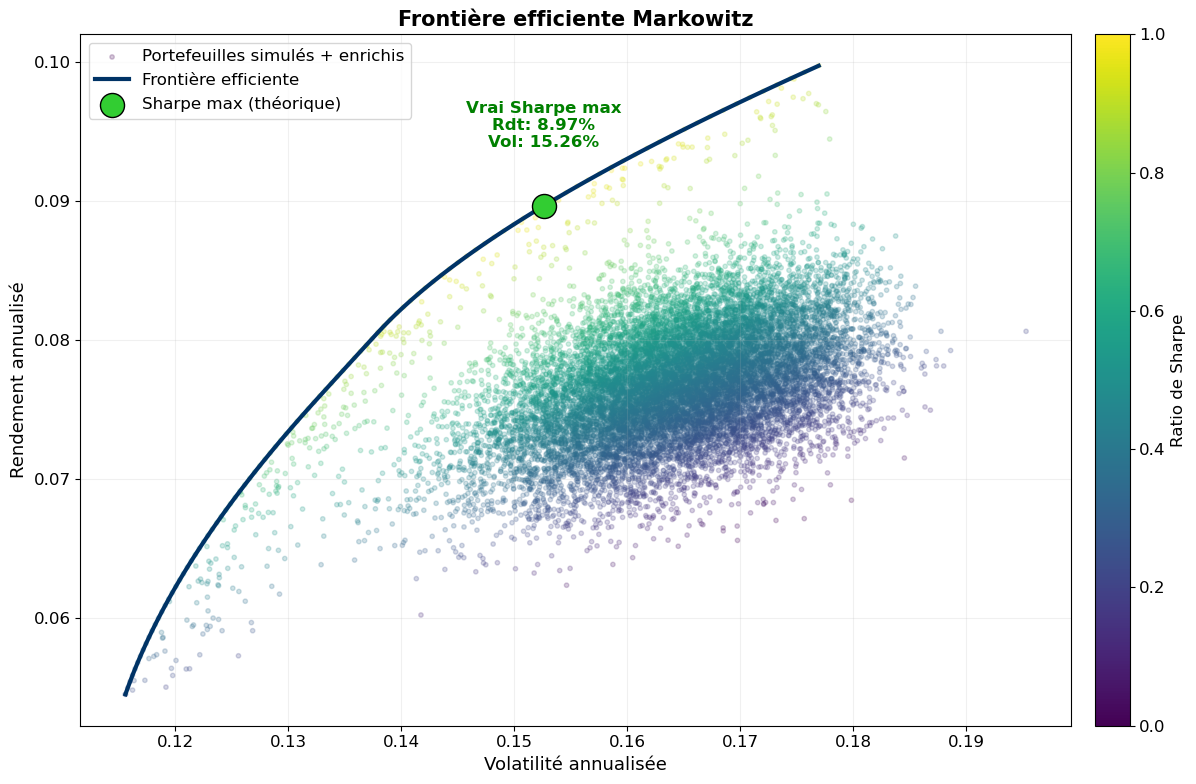

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
returns = act_daily_ret_train_df
# --- Paramètres ---
lb, ub = 0.1, 0.4        # Contraintes sur les poids
risk_free = 0.015        # Taux sans risque annualisé
freq = 252               # Annualisation (journalière)
num_portfolios = 15000   # Nombre de portefeuilles simulés
n_samples_noise = 20     # Nombre de portefeuilles bruités par point de frontière

# --- Génération du nuage annualisé ---
def random_weights_lb_ub(n, lb, ub):
    while True:
        w = np.random.uniform(lb, ub, n)
        w /= w.sum()
        if np.all(w >= lb) and np.all(w <= ub):
            return w

def generate_random_portfolios_constrained(returns, num_portfolios=15000, lb=0.1, ub=0.4, risk_free=0.015, freq=252):
    num_assets = returns.shape[1]
    mean_returns = returns.mean() * freq
    cov_matrix = returns.cov() * freq
    results = []
    for _ in range(num_portfolios):
        w = random_weights_lb_ub(num_assets, lb, ub)
        port_ret = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (port_ret - risk_free) / port_vol if port_vol > 0 else 0
        results.append(np.hstack([port_vol, port_ret, sharpe, w]))
    return np.array(results)

# --- Simulation du nuage ---
portfolios = generate_random_portfolios_constrained(
    act_daily_ret_train_df, num_portfolios=num_portfolios, lb=lb, ub=ub, risk_free=risk_free, freq=freq
)
col_names = ['Volatilité', 'Rendement', 'Sharpe'] + list(act_daily_ret_train_df.columns)
portfolios_df = pd.DataFrame(portfolios, columns=col_names)

# --- Vraie frontière efficiente par optimisation quadratique ---
mean_returns = act_daily_ret_train_df.mean() * freq
cov_matrix = act_daily_ret_train_df.cov() * freq
num_assets = len(mean_returns)

def min_vol_target_return(mean_returns, cov_matrix, target_return, lb, ub):
    n = len(mean_returns)
    bounds = tuple((lb, ub) for _ in range(n))
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}
    )
    x0 = np.repeat(1/n, n)
    def port_vol(w): return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    result = minimize(port_vol, x0=x0, bounds=bounds, constraints=constraints)
    return result

def min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False):
    n = len(mean_returns)
    bounds = tuple((lb, ub) for _ in range(n))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    sign = -1 if maximize else 1
    result = minimize(lambda w: sign * np.dot(w, mean_returns),
                      x0=np.repeat(1/n, n), bounds=bounds, constraints=cons)
    return np.dot(result.x, mean_returns)

min_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False)
max_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=True)
target_returns = np.linspace(min_return, max_return, 100)

frontier_vol = []
frontier_ret = []
frontier_weights = []

for target in target_returns:
    res = min_vol_target_return(mean_returns, cov_matrix, target, lb, ub)
    if res.success:
        w_opt = res.x
        v = np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix, w_opt)))
        r = np.dot(w_opt, mean_returns)
        frontier_vol.append(v)
        frontier_ret.append(r)
        frontier_weights.append(w_opt)
        # Ajoute le portefeuille optimal au nuage (visibilité maximale sur la frontière)
        sharpe = (r - risk_free) / v if v > 0 else 0
        portfolios_df.loc[len(portfolios_df)] = [v, r, sharpe] + list(w_opt)
        # Génère des portefeuilles bruités autour de la frontière
        for _ in range(n_samples_noise):
            w_noisy = w_opt + np.random.normal(0, 0.02, size=len(w_opt))
            w_noisy = np.clip(w_noisy, lb, ub)
            w_noisy /= w_noisy.sum()
            if np.all(w_noisy >= lb) and np.all(w_noisy <= ub):
                port_ret = np.dot(w_noisy, mean_returns)
                port_vol = np.sqrt(np.dot(w_noisy.T, np.dot(cov_matrix, w_noisy)))
                sharpe = (port_ret - risk_free) / port_vol if port_vol > 0 else 0
                portfolios_df.loc[len(portfolios_df)] = [port_vol, port_ret, sharpe] + list(w_noisy)
    else:
        frontier_vol.append(np.nan)
        frontier_ret.append(np.nan)
        frontier_weights.append(np.full(num_assets, np.nan))

# --- Vrai portefeuille Sharpe max par optimisation ---
def sharpe_neg(w, mean_returns, cov_matrix, risk_free):
    port_ret = np.dot(w, mean_returns)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return - (port_ret - risk_free) / port_vol

bounds = tuple((lb, ub) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
x0 = np.repeat(1/num_assets, num_assets)
res_sharpe_opt = minimize(sharpe_neg, x0=x0, args=(mean_returns, cov_matrix, risk_free), bounds=bounds, constraints=constraints)
w_sharpe_opt = res_sharpe_opt.x
ret_sharpe_opt = np.dot(w_sharpe_opt, mean_returns)
vol_sharpe_opt = np.sqrt(np.dot(w_sharpe_opt.T, np.dot(cov_matrix, w_sharpe_opt)))
sharpe_opt = (ret_sharpe_opt - risk_free) / vol_sharpe_opt

# --- Tracé graphique final ---
plt.figure(figsize=(13, 8))
plt.scatter(
    portfolios_df['Volatilité'], portfolios_df['Rendement'],
    c=portfolios_df['Sharpe'], cmap='viridis', alpha=0.22, s=10, label='Portefeuilles simulés + enrichis'
)
plt.plot(
    frontier_vol, frontier_ret,
    color='#003366', lw=3, label='Frontière efficiente', zorder=5
)
plt.scatter(
    vol_sharpe_opt, ret_sharpe_opt,
    c='limegreen', marker='o', s=300, edgecolors='black', zorder=10, label='Sharpe max (théorique)'
)
plt.text(
    vol_sharpe_opt, ret_sharpe_opt + 0.004,
    f"Vrai Sharpe max\nRdt: {ret_sharpe_opt:.2%}\nVol: {vol_sharpe_opt:.2%}",
    fontsize=12, color='green', ha='center', va='bottom', fontweight='bold'
)
plt.xlabel('Volatilité annualisée', fontsize=13)
plt.ylabel('Rendement annualisé', fontsize=13)
plt.title(
    f'Frontière efficiente Markowitz',
    fontsize=15, fontweight='bold'
)
plt.colorbar(label='Ratio de Sharpe', pad=0.02)
plt.grid(alpha=0.18)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

# --- Poids du VRAI Sharpe max (optionnel) ---
import pandas as pd

# Construction du DataFrame à partir des résultats
df_sharpe = pd.DataFrame({
    "Titre": act_daily_ret_train_df.columns,
    "Poids du portefeuille Sharpe max (%)": [poids * 100 for poids in w_sharpe_opt]
})

# Affichage joli dans Jupyter
import pandas as pd
import numpy as np

# Calcul des rendements annualisés et volatilités annualisées par titre
mean_daily_returns = act_daily_ret_train_df.mean()
vol_daily = act_daily_ret_train_df.std()
rendements_annualises = mean_daily_returns * 252 * 100  # en %
volatilite_annualisee = vol_daily * np.sqrt(252) * 100  # en %

# DataFrame récapitulatif
df_sharpe = pd.DataFrame({
    "Titre": act_daily_ret_train_df.columns,
    "Poids (%)": [w * 100 for w in w_sharpe_opt],
    "Rendement annualisé (%)": rendements_annualises.values,
    "Volatilité annualisée (%)": volatilite_annualisee.values
})

# Affichage joli (Jupyter ou export)
from IPython.display import display, HTML
display(HTML(df_sharpe.to_html(index=False, float_format="%.2f")))

# Calcul des métriques du portefeuille
port_return_ann = np.dot(w_sharpe_opt, mean_daily_returns) * 252 * 100
port_vol_ann = np.sqrt(np.dot(w_sharpe_opt, np.dot(act_daily_ret_train_df.cov(), w_sharpe_opt))) * np.sqrt(252) * 100
port_sharpe = port_return_ann / port_vol_ann

# Tableau récapitulatif du portefeuille Sharpe max
df_portfolio = pd.DataFrame({
    "Rendement annualisé (%)": [port_return_ann],
    "Volatilité annualisée (%)": [port_vol_ann],
    "Ratio de Sharpe": [port_sharpe]
})

# Affichage joli dans Jupyter ou export
from IPython.display import display, HTML
display(HTML(df_portfolio.to_html(index=False, float_format="%.2f")))


In [125]:
print(pred_daily_ret_df.cov())
print(pred_daily_ret_df.mean())
print(pred_daily_ret_df.std())
print(pred_daily_ret_df.isna().sum())


          SPY       QQQ       VEA       BND       GLD       IWM       VNQ
SPY  0.000031  0.000034  0.000042  0.000004  0.000009  0.000058  0.000046
QQQ  0.000034  0.000047  0.000042  0.000005  0.000010  0.000058  0.000046
VEA  0.000042  0.000042  0.000089  0.000008  0.000031  0.000093  0.000078
BND  0.000004  0.000005  0.000008  0.000008  0.000008  0.000007  0.000013
GLD  0.000009  0.000010  0.000031  0.000008  0.000066  0.000020  0.000025
IWM  0.000058  0.000058  0.000093  0.000007  0.000020  0.000159  0.000114
VNQ  0.000046  0.000046  0.000078  0.000013  0.000025  0.000114  0.000138
SPY    0.000302
QQQ    0.000442
VEA    0.000269
BND   -0.000051
GLD    0.000488
IWM    0.000187
VNQ   -0.000196
dtype: float32
SPY    0.005537
QQQ    0.006857
VEA    0.009417
BND    0.002745
GLD    0.008120
IWM    0.012629
VNQ    0.011768
dtype: float32
SPY    0
QQQ    0
VEA    0
BND    0
GLD    0
IWM    0
VNQ    0
dtype: int64


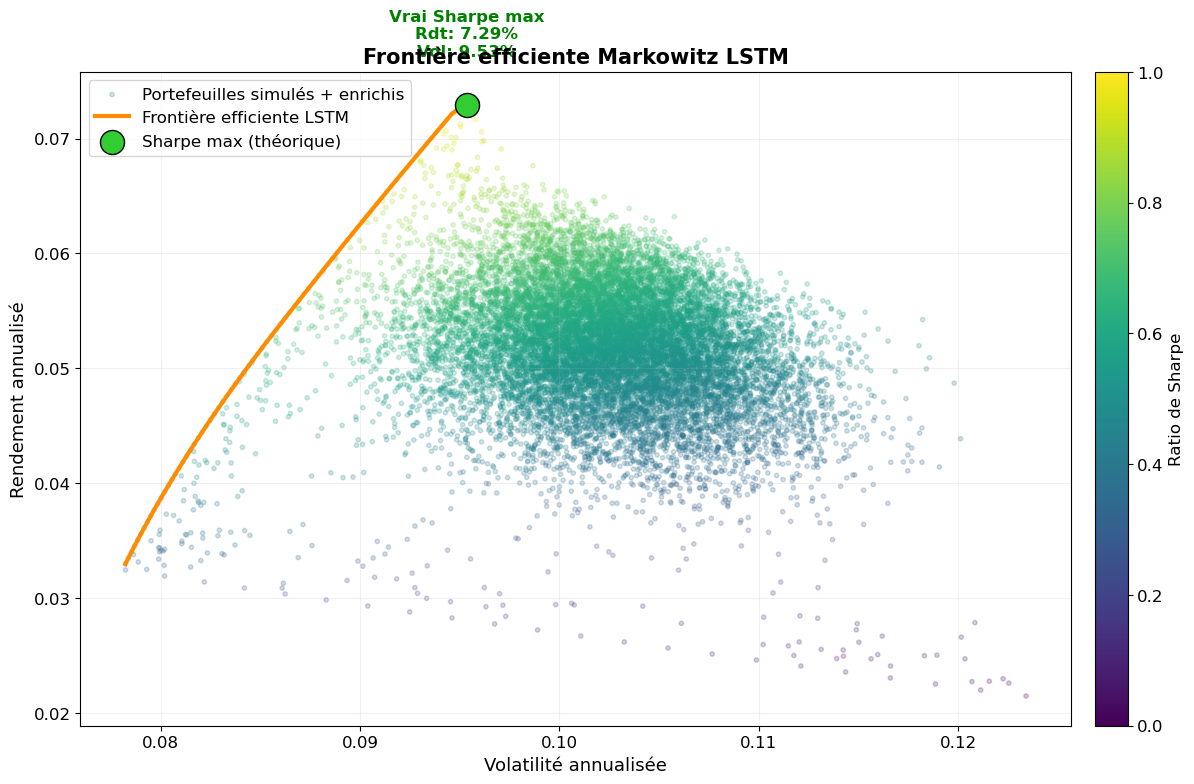


Poids du VRAI portefeuille Sharpe max (théorique LSTM) :
SPY: 10.00%
QQQ: 12.50%
VEA: 10.00%
BND: 10.00%
GLD: 37.50%
IWM: 10.00%
VNQ: 10.00%


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === On part sur les rendements LSTM sur la période de test ===
returns = pred_daily_ret_df

# --- Paramètres ---
lb, ub = 0.1, 0.4        # Contraintes sur les poids
risk_free = 0.015        # Taux sans risque annualisé
freq = 252               # Annualisation (journalière)
num_portfolios = 15000   # Nombre de portefeuilles simulés
n_samples_noise = 20     # Nombre de portefeuilles bruités par point de frontière

# --- Génération du nuage annualisé ---
def random_weights_lb_ub(n, lb, ub):
    while True:
        w = np.random.uniform(lb, ub, n)
        w /= w.sum()
        if np.all(w >= lb) and np.all(w <= ub):
            return w

def generate_random_portfolios_constrained(returns, num_portfolios=15000, lb=0.1, ub=0.4, risk_free=0.015, freq=252):
    num_assets = returns.shape[1]
    mean_returns = returns.mean() * freq
    cov_matrix = returns.cov() * freq
    results = []
    for _ in range(num_portfolios):
        w = random_weights_lb_ub(num_assets, lb, ub)
        port_ret = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (port_ret - risk_free) / port_vol if port_vol > 0 else 0
        results.append(np.hstack([port_vol, port_ret, sharpe, w]))
    return np.array(results)

# --- Simulation du nuage ---
portfolios = generate_random_portfolios_constrained(
    returns, num_portfolios=num_portfolios, lb=lb, ub=ub, risk_free=risk_free, freq=freq
)
col_names = ['Volatilité', 'Rendement', 'Sharpe'] + list(returns.columns)
portfolios_df = pd.DataFrame(portfolios, columns=col_names)

# --- Vraie frontière efficiente par optimisation quadratique ---
mean_returns = returns.mean() * freq
cov_matrix = returns.cov() * freq
num_assets = len(mean_returns)

def min_vol_target_return(mean_returns, cov_matrix, target_return, lb, ub):
    n = len(mean_returns)
    bounds = tuple((lb, ub) for _ in range(n))
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}
    )
    x0 = np.repeat(1/n, n)
    def port_vol(w): return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    result = minimize(port_vol, x0=x0, bounds=bounds, constraints=constraints)
    return result

def min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False):
    n = len(mean_returns)
    bounds = tuple((lb, ub) for _ in range(n))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    sign = -1 if maximize else 1
    result = minimize(lambda w: sign * np.dot(w, mean_returns),
                      x0=np.repeat(1/n, n), bounds=bounds, constraints=cons)
    return np.dot(result.x, mean_returns)

min_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False)
max_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=True)
target_returns = np.linspace(min_return, max_return, 100)

frontier_vol = []
frontier_ret = []
frontier_weights = []

for target in target_returns:
    res = min_vol_target_return(mean_returns, cov_matrix, target, lb, ub)
    if res.success:
        w_opt = res.x
        v = np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix, w_opt)))
        r = np.dot(w_opt, mean_returns)
        frontier_vol.append(v)
        frontier_ret.append(r)
        frontier_weights.append(w_opt)
        # Ajoute le portefeuille optimal au nuage (visibilité maximale sur la frontière)
        sharpe = (r - risk_free) / v if v > 0 else 0
        portfolios_df.loc[len(portfolios_df)] = [v, r, sharpe] + list(w_opt)
        # Génère des portefeuilles bruités autour de la frontière
        for _ in range(n_samples_noise):
            w_noisy = w_opt + np.random.normal(0, 0.02, size=len(w_opt))
            w_noisy = np.clip(w_noisy, lb, ub)
            w_noisy /= w_noisy.sum()
            if np.all(w_noisy >= lb) and np.all(w_noisy <= ub):
                port_ret = np.dot(w_noisy, mean_returns)
                port_vol = np.sqrt(np.dot(w_noisy.T, np.dot(cov_matrix, w_noisy)))
                sharpe = (port_ret - risk_free) / port_vol if port_vol > 0 else 0
                portfolios_df.loc[len(portfolios_df)] = [port_vol, port_ret, sharpe] + list(w_noisy)
    else:
        frontier_vol.append(np.nan)
        frontier_ret.append(np.nan)
        frontier_weights.append(np.full(num_assets, np.nan))

# --- Filtrage de la frontière supérieure (croissante) ---
frontier_vol = np.array(frontier_vol)
frontier_ret = np.array(frontier_ret)
mask_valid = (~np.isnan(frontier_vol)) & (~np.isnan(frontier_ret)) & (frontier_vol > 0)
frontier_vol = frontier_vol[mask_valid]
frontier_ret = frontier_ret[mask_valid]
idx_sorted = np.argsort(frontier_vol)
frontier_vol_sorted = frontier_vol[idx_sorted]
frontier_ret_sorted = frontier_ret[idx_sorted]
frontier_vol_clean = []
frontier_ret_clean = []
max_ret = -np.inf
for v, r in zip(frontier_vol_sorted, frontier_ret_sorted):
    if r > max_ret:
        frontier_vol_clean.append(v)
        frontier_ret_clean.append(r)
        max_ret = r
frontier_vol_clean = np.array(frontier_vol_clean)
frontier_ret_clean = np.array(frontier_ret_clean)

# --- Vrai portefeuille Sharpe max par optimisation ---
def sharpe_neg(w, mean_returns, cov_matrix, risk_free):
    port_ret = np.dot(w, mean_returns)
    port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return - (port_ret - risk_free) / port_vol

bounds = tuple((lb, ub) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
x0 = np.repeat(1/num_assets, num_assets)
res_sharpe_opt = minimize(sharpe_neg, x0=x0, args=(mean_returns, cov_matrix, risk_free), bounds=bounds, constraints=constraints)
w_sharpe_opt = res_sharpe_opt.x
ret_sharpe_opt = np.dot(w_sharpe_opt, mean_returns)
vol_sharpe_opt = np.sqrt(np.dot(w_sharpe_opt.T, np.dot(cov_matrix, w_sharpe_opt)))
sharpe_opt = (ret_sharpe_opt - risk_free) / vol_sharpe_opt

# --- Tracé graphique final ---
plt.figure(figsize=(13, 8))
plt.scatter(
    portfolios_df['Volatilité'], portfolios_df['Rendement'],
    c=portfolios_df['Sharpe'], cmap='viridis', alpha=0.22, s=10, label='Portefeuilles simulés + enrichis'
)
plt.plot(
    frontier_vol_clean, frontier_ret_clean,
    color='darkorange', lw=3, label='Frontière efficiente LSTM', zorder=5
)
plt.scatter(
    vol_sharpe_opt, ret_sharpe_opt,
    c='limegreen', marker='o', s=300, edgecolors='black', zorder=10, label='Sharpe max (théorique)'
)
plt.text(
    vol_sharpe_opt, ret_sharpe_opt + 0.004,
    f"Vrai Sharpe max\nRdt: {ret_sharpe_opt:.2%}\nVol: {vol_sharpe_opt:.2%}",
    fontsize=12, color='green', ha='center', va='bottom', fontweight='bold'
)
plt.xlabel('Volatilité annualisée', fontsize=13)
plt.ylabel('Rendement annualisé', fontsize=13)
plt.title(
    f'Frontière efficiente Markowitz LSTM',
    fontsize=15, fontweight='bold'
)
plt.colorbar(label='Ratio de Sharpe', pad=0.02)
plt.grid(alpha=0.18)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

# --- Poids du VRAI Sharpe max (optionnel) ---
print("\nPoids du VRAI portefeuille Sharpe max (théorique LSTM) :")
for titre, poids in zip(returns.columns, w_sharpe_opt):
    print(f"{titre}: {poids:.2%}")



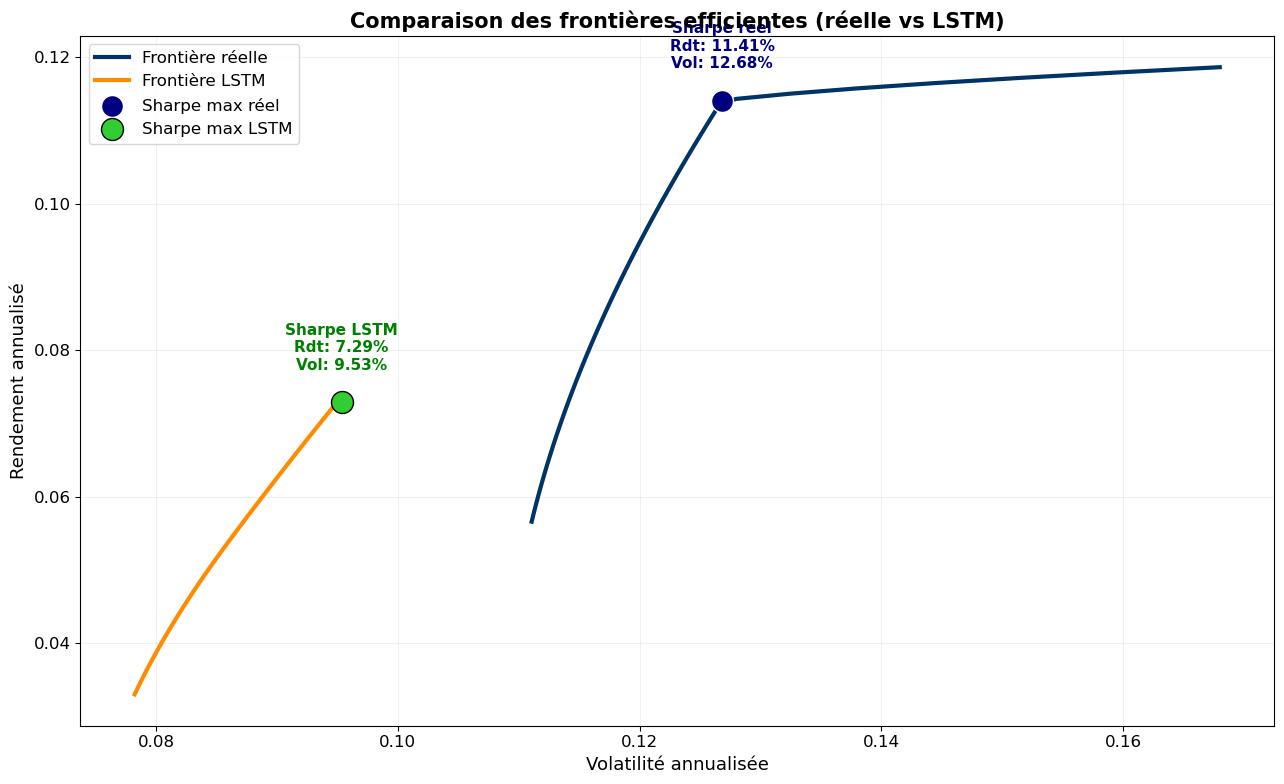


Poids du Sharpe max RÉEL :
SPY: 10.00%
QQQ: 10.00%
VEA: 10.00%
BND: 10.00%
GLD: 40.00%
IWM: 10.00%
VNQ: 10.00%

Poids du Sharpe max LSTM :
SPY: 10.00%
QQQ: 12.50%
VEA: 10.00%
BND: 10.00%
GLD: 37.50%
IWM: 10.00%
VNQ: 10.00%

=== MÉTRIQUES SUR LA PÉRIODE DE TEST ===
Portefeuille optimal HISTORIQUE :
  Rendement annualisé : 11.41%
  Volatilité annualisée : 12.68%
  Ratio de Sharpe : 0.78

Portefeuille optimal LSTM :
  Rendement annualisé : 7.29%
  Volatilité annualisée : 9.53%
  Ratio de Sharpe : 0.61


In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Fonction pour calculer la frontière efficiente et le Sharpe max ===
def compute_markowitz_frontier(returns, lb=0.1, ub=0.4, risk_free=0.015, freq=252, points=100):
    num_assets = returns.shape[1]
    mean_returns = returns.mean() * freq
    cov_matrix = returns.cov() * freq

    # Génération de la frontière efficiente (quadratique)
    def min_vol_target_return(mean_returns, cov_matrix, target_return, lb, ub):
        bounds = tuple((lb, ub) for _ in range(num_assets))
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}
        )
        x0 = np.repeat(1/num_assets, num_assets)
        def port_vol(w): return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        result = minimize(port_vol, x0=x0, bounds=bounds, constraints=constraints)
        return result

    def min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False):
        bounds = tuple((lb, ub) for _ in range(num_assets))
        cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
        sign = -1 if maximize else 1
        result = minimize(lambda w: sign * np.dot(w, mean_returns),
                          x0=np.repeat(1/num_assets, num_assets), bounds=bounds, constraints=cons)
        return np.dot(result.x, mean_returns)

    min_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=False)
    max_return = min_or_max_portfolio_return(mean_returns, lb, ub, maximize=True)
    target_returns = np.linspace(min_return, max_return, points)

    frontier_vol = []
    frontier_ret = []
    for target in target_returns:
        res = min_vol_target_return(mean_returns, cov_matrix, target, lb, ub)
        if res.success:
            w_opt = res.x
            v = np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix, w_opt)))
            r = np.dot(w_opt, mean_returns)
            frontier_vol.append(v)
            frontier_ret.append(r)

    # Filtrage de la frontière supérieure strictement croissante
    frontier_vol = np.array(frontier_vol)
    frontier_ret = np.array(frontier_ret)
    idx_sorted = np.argsort(frontier_vol)
    fvol, fret = frontier_vol[idx_sorted], frontier_ret[idx_sorted]
    fvol_clean, fret_clean, max_r = [], [], -np.inf
    for v, r in zip(fvol, fret):
        if r > max_r:
            fvol_clean.append(v)
            fret_clean.append(r)
            max_r = r

    # Sharpe max (optimisé)
    def sharpe_neg(w, mean_returns, cov_matrix, risk_free):
        port_ret = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return - (port_ret - risk_free) / port_vol
    bounds = tuple((lb, ub) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    x0 = np.repeat(1/num_assets, num_assets)
    res_sharpe = minimize(sharpe_neg, x0=x0, args=(mean_returns, cov_matrix, risk_free), bounds=bounds, constraints=constraints)
    w_sharpe = res_sharpe.x
    ret_sharpe = np.dot(w_sharpe, mean_returns)
    vol_sharpe = np.sqrt(np.dot(w_sharpe.T, np.dot(cov_matrix, w_sharpe)))
    sharpe = (ret_sharpe - risk_free) / vol_sharpe

    return (np.array(fvol_clean), np.array(fret_clean), vol_sharpe, ret_sharpe, w_sharpe, sharpe)

# --- Calcul des deux frontières et Sharpe max ---
lb, ub = 0.1, 0.4        # bornes poids
risk_free = 0.015
freq = 252

frontier_vol_real, frontier_ret_real, vol_sharpe_real, ret_sharpe_real, w_sharpe_real, sharpe_real = compute_markowitz_frontier(
    act_daily_ret_df, lb, ub, risk_free, freq, points=100
)
frontier_vol_lstm, frontier_ret_lstm, vol_sharpe_lstm, ret_sharpe_lstm, w_sharpe_lstm, sharpe_lstm = compute_markowitz_frontier(
    pred_daily_ret_df, lb, ub, risk_free, freq, points=100
)

# --- Affichage comparatif ---
plt.figure(figsize=(13, 8))
plt.plot(frontier_vol_real, frontier_ret_real, color='#003366', lw=3, label='Frontière réelle', zorder=5)
plt.plot(frontier_vol_lstm, frontier_ret_lstm, color='darkorange', lw=3, label='Frontière LSTM', zorder=6)
plt.scatter(vol_sharpe_real, ret_sharpe_real, c='navy', marker='o', s=250, edgecolors='white', zorder=10, label='Sharpe max réel')
plt.scatter(vol_sharpe_lstm, ret_sharpe_lstm, c='limegreen', marker='o', s=250, edgecolors='black', zorder=10, label='Sharpe max LSTM')
plt.text(
    vol_sharpe_real, ret_sharpe_real + 0.004,
    f"Sharpe réel\nRdt: {ret_sharpe_real:.2%}\nVol: {vol_sharpe_real:.2%}",
    fontsize=11, color='navy', ha='center', va='bottom', fontweight='bold'
)
plt.text(
    vol_sharpe_lstm, ret_sharpe_lstm + 0.004,
    f"Sharpe LSTM\nRdt: {ret_sharpe_lstm:.2%}\nVol: {vol_sharpe_lstm:.2%}",
    fontsize=11, color='green', ha='center', va='bottom', fontweight='bold'
)
plt.xlabel('Volatilité annualisée', fontsize=13)
plt.ylabel('Rendement annualisé', fontsize=13)
plt.title('Comparaison des frontières efficientes (réelle vs LSTM)', fontsize=15, fontweight='bold')
plt.grid(alpha=0.18)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

# --- Affichage des poids Sharpe max (optionnel) ---
print("\nPoids du Sharpe max RÉEL :")
for titre, poids in zip(act_daily_ret_df.columns, w_sharpe_real):
    print(f"{titre}: {poids:.2%}")

print("\nPoids du Sharpe max LSTM :")
for titre, poids in zip(pred_daily_ret_df.columns, w_sharpe_lstm):
    print(f"{titre}: {poids:.2%}")
# --- Affichage des métriques rendement, risque, Sharpe réalisés sur la période test ---
def port_metrics(weights, returns, risk_free=0.015, freq=252):
    mean_ret = returns.mean() * freq
    cov_matrix = returns.cov() * freq
    port_return = np.dot(weights, mean_ret)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free) / port_vol
    return port_return, port_vol, sharpe

ret_real, vol_real, sharpe_real = port_metrics(w_sharpe_real, act_daily_ret_df, risk_free, freq)
ret_lstm, vol_lstm, sharpe_lstm = port_metrics(w_sharpe_lstm, pred_daily_ret_df, risk_free, freq)

print("\n=== MÉTRIQUES SUR LA PÉRIODE DE TEST ===")
print("Portefeuille optimal HISTORIQUE :")
print(f"  Rendement annualisé : {ret_real:.2%}")
print(f"  Volatilité annualisée : {vol_real:.2%}")
print(f"  Ratio de Sharpe : {sharpe_real:.2f}")

print("\nPortefeuille optimal LSTM :")
print(f"  Rendement annualisé : {ret_lstm:.2%}")
print(f"  Volatilité annualisée : {vol_lstm:.2%}")
print(f"  Ratio de Sharpe : {sharpe_lstm:.2f}")

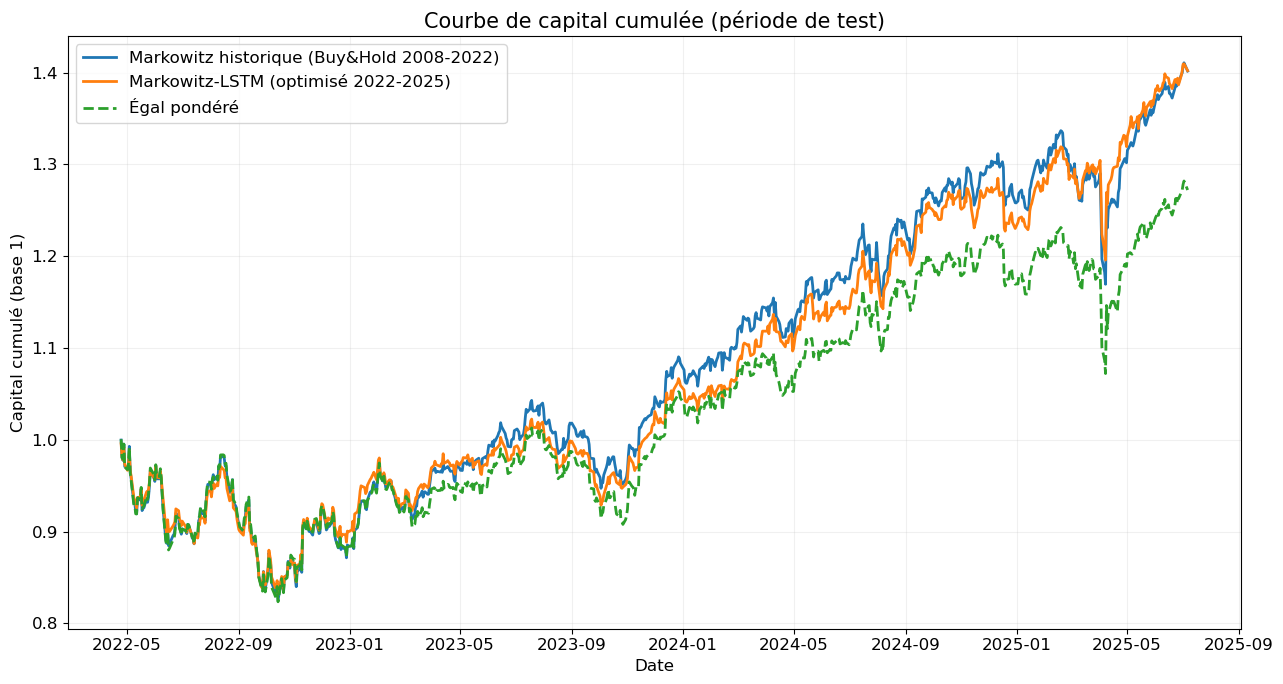

                      Rdt Annuel  Vol Ann.  Sharpe  Max Drawdown
Markowitz historique       0.116     0.144   0.705         0.174
Markowitz-LSTM             0.114     0.129   0.772         0.165
Égal pondéré               0.086     0.144   0.492         0.177

Poids des actifs (en %) pour chaque méthode :

                         SPY     QQQ     VEA     BND     GLD     IWM     VNQ
Markowitz historique  10.00%  25.37%  10.00%  10.00%  24.63%  10.00%  10.00%
Markowitz-LSTM        10.00%  12.50%  10.00%  10.00%  37.50%  10.00%  10.00%
Égal pondéré          14.29%  14.29%  14.29%  14.29%  14.29%  14.29%  14.29%


In [155]:
# 1. Poids Markowitz "historiques" : optimisés sur act_daily_ret_train_df (2008-2022), appliqués en buy&hold sur 2022-2025
mean_returns_train = act_daily_ret_train_df.mean() * 252
cov_matrix_train = act_daily_ret_train_df.cov() * 252

from scipy.optimize import minimize

def get_markowitz_weights(mean_returns, cov_matrix, lb, ub, risk_free):
    num_assets = len(mean_returns)
    def sharpe_neg(w):
        port_ret = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return - (port_ret - risk_free) / port_vol
    bounds = tuple((lb, ub) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
    x0 = np.repeat(1/num_assets, num_assets)
    res = minimize(sharpe_neg, x0=x0, bounds=bounds, constraints=constraints)
    return res.x

poids_bh_markowitz = get_markowitz_weights(mean_returns_train, cov_matrix_train, lb, ub, risk_free)
poids_equal = np.repeat(1/len(mean_returns_train), len(mean_returns_train))

# 2. Poids Markowitz-LSTM optimisés sur toute la période 2022-2025 (ex: recalculé périodiquement)
mean_returns_lstm = pred_daily_ret_df.mean() * 252
cov_matrix_lstm   = pred_daily_ret_df.cov() * 252
poids_markowitz_lstm = get_markowitz_weights(mean_returns_lstm, cov_matrix_lstm, lb, ub, risk_free)

# 3. Générer les courbes de capital
def portefeuille_curve(returns, weights):
    # On part d'un capital de 1
    weighted_ret = (returns * weights).sum(axis=1)
    capital = (1 + weighted_ret).cumprod()
    return capital

capital_bh_markowitz = portefeuille_curve(act_daily_ret_df, poids_bh_markowitz)
capital_lstm_markowitz = portefeuille_curve(act_daily_ret_df, poids_markowitz_lstm)
capital_equal = portefeuille_curve(act_daily_ret_df, poids_equal)

# 4. Affichage comparatif
plt.figure(figsize=(13, 7))
plt.plot(capital_bh_markowitz, label="Markowitz historique (Buy&Hold 2008-2022)", lw=2)
plt.plot(capital_lstm_markowitz, label="Markowitz-LSTM (optimisé 2022-2025)", lw=2)
plt.plot(capital_equal, label="Égal pondéré", lw=2, linestyle='--')
plt.title("Courbe de capital cumulée (période de test)", fontsize=15)
plt.ylabel("Capital cumulé (base 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.18)
plt.tight_layout()
plt.show()
import numpy as np

def performance_stats(returns, weights, risk_free=0.015, freq=252):
    portf_returns = (returns * weights).sum(axis=1)
    mean_ann = portf_returns.mean() * freq
    vol_ann = portf_returns.std() * np.sqrt(freq)
    sharpe_ann = (mean_ann - risk_free) / vol_ann if vol_ann > 0 else np.nan
    drawdown = (1 + portf_returns).cumprod()
    dd = 1 - drawdown / np.maximum.accumulate(drawdown)
    max_dd = dd.max()
    return mean_ann, vol_ann, sharpe_ann, max_dd

perf_bh = performance_stats(act_daily_ret_df, poids_bh_markowitz)
perf_lstm = performance_stats(act_daily_ret_df, poids_markowitz_lstm)
perf_eq = performance_stats(act_daily_ret_df, poids_equal)

# Affiche tableau comparatif
import pandas as pd
perf_table = pd.DataFrame(
    [perf_bh, perf_lstm, perf_eq],
    columns=["Rdt Annuel", "Vol Ann.", "Sharpe", "Max Drawdown"],
    index=["Markowitz historique", "Markowitz-LSTM", "Égal pondéré"]
)
print(perf_table.round(3))
# --- Affichage des poids pour chaque méthode ---
# --- Affichage des poids pour chaque méthode (compatible pandas >= 3.0) ---
print("\nPoids des actifs (en %) pour chaque méthode :\n")
poids_table_percent = poids_table.astype(float).apply(lambda col: col.map(lambda x: f"{100*x:.2f}%"))
print(poids_table_percent)




In [173]:
from IPython.display import display, HTML

# Table des performances
display(HTML(perf_table.round(3)
    .style.set_caption("Tableau des performances des portefeuilles")
    .set_table_styles([{"selector":"caption","props":[("text-align","left"), ("font-weight","bold")]}])
    .background_gradient(cmap="Purples")
    .format(precision=3)
    .to_html()))

# Table des poids (en %)
print("\nPoids des actifs (en %) pour chaque méthode :\n")
poids_table_percent = poids_table.astype(float).applymap(lambda x: f"{100*x:.2f} %")
display(HTML(poids_table_percent
    .style.set_caption("Poids des actifs (en %) pour chaque méthode")
    .set_table_styles([{"selector":"caption","props":[("text-align","left"), ("font-weight","bold")]}])
    .to_html()))



Poids des actifs (en %) pour chaque méthode :



/tmp/ipykernel_11749/4256836746.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  poids_table_percent = poids_table.astype(float).applymap(lambda x: f"{100*x:.2f} %")


In [133]:
import numpy as np

def performance_stats(returns, weights, risk_free=0.015, freq=252):
    portf_returns = (returns * weights).sum(axis=1)
    mean_ann = portf_returns.mean() * freq
    vol_ann = portf_returns.std() * np.sqrt(freq)
    sharpe_ann = (mean_ann - risk_free) / vol_ann if vol_ann > 0 else np.nan
    drawdown = (1 + portf_returns).cumprod()
    dd = 1 - drawdown / np.maximum.accumulate(drawdown)
    max_dd = dd.max()
    return mean_ann, vol_ann, sharpe_ann, max_dd

perf_bh = performance_stats(act_daily_ret_df, poids_bh_markowitz)
perf_lstm = performance_stats(act_daily_ret_df, poids_markowitz_lstm)
perf_eq = performance_stats(act_daily_ret_df, poids_equal)

# Affiche tableau comparatif
import pandas as pd
perf_table = pd.DataFrame(
    [perf_bh, perf_lstm, perf_eq],
    columns=["Rdt Annuel", "Vol Ann.", "Sharpe", "Max Drawdown"],
    index=["Markowitz historique", "Markowitz-LSTM", "Égal pondéré"]
)
print(perf_table.round(3))


                      Rdt Annuel  Vol Ann.  Sharpe  Max Drawdown
Markowitz historique       0.116     0.144   0.705         0.174
Markowitz-LSTM             0.114     0.129   0.772         0.165
Égal pondéré               0.086     0.144   0.492         0.177


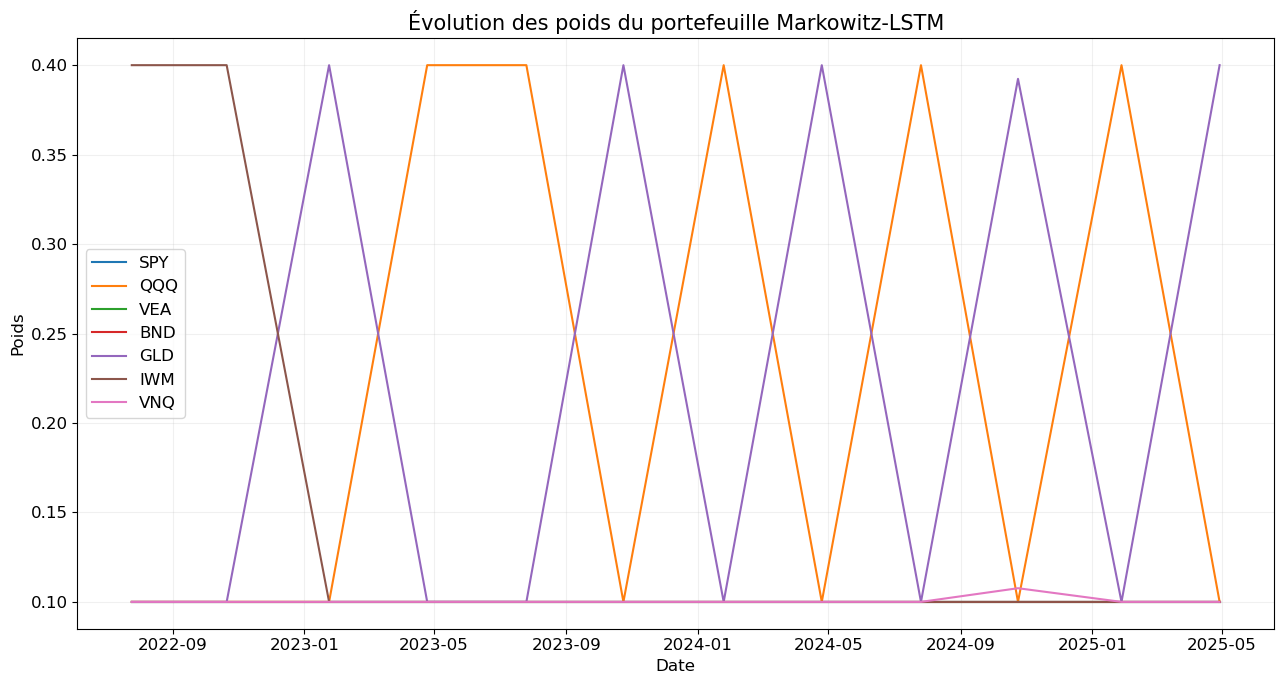

In [149]:
# Pour visualiser la stabilité des poids sur la période de test,
# tu peux recalculer le portefeuille Markowitz-LSTM chaque mois ou trimestre et afficher l'évolution des poids

window_size = 21*3  # 3 mois, ajuste selon ta granularité
dates = []
poids_lstm_evol = []
for i in range(0, len(pred_daily_ret_df)-window_size, window_size):
    win = pred_daily_ret_df.iloc[i:i+window_size]
    mean_ret_win = win.mean() * 252
    cov_win = win.cov() * 252
    poids_win = get_markowitz_weights(mean_ret_win, cov_win, lb, ub, risk_free)
    poids_lstm_evol.append(poids_win)
    dates.append(win.index[-1])

poids_lstm_evol = np.array(poids_lstm_evol)
plt.figure(figsize=(13, 7))
for idx, col in enumerate(pred_daily_ret_df.columns):
    plt.plot(dates, poids_lstm_evol[:, idx], label=col)
plt.title("Évolution des poids du portefeuille Markowitz-LSTM", fontsize=15)
plt.ylabel("Poids")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.18)
plt.tight_layout()
plt.show()


In [151]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose que best_weights_constr = np.array([...])  # (déjà récupéré après optimisation)
# Utilise les rendements journaliers réels sur la période d'étude
# (Par exemple, sur la période de validation/test si tu sépares train/test)

# Calcul du rendement journalier du portefeuille
port_ret = act_daily_ret_df.dot(best_weights_constr)

# Courbe de valeur cumulée (base 100)
cumulative = (1 + port_ret).cumprod() * 100

plt.figure(figsize=(10,5))
plt.plot(cumulative, lw=2, color='darkorange', label='Portefeuille optimal 10–40%')
plt.title('Évolution de la valeur du portefeuille optimal (10–40%)')
plt.ylabel('Valeur cumulée (base 100)')
plt.xlabel('Date')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'best_weights_constr' is not defined

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# === Utilise act_daily_ret_df qui contient les rendements journaliers de la période de TEST (validation) ===
# (Shape: 801 x 7 ou similaire selon ton split)

# Calcul du rendement quotidien du portefeuille optimal sur la période de test
port_ret_test = act_daily_ret_df.dot(best_weights_constr)
cumulative_test = (1 + port_ret_test).cumprod() * 100

# Statistiques de performance
annual_ret_test = port_ret_test.mean() * 252
annual_vol_test = port_ret_test.std() * np.sqrt(252)
sharpe_test = (annual_ret_test - 0.015) / annual_vol_test
rolling_max_test = cumulative_test.cummax()
drawdown_test = (cumulative_test - rolling_max_test) / rolling_max_test
max_drawdown_test = drawdown_test.min()

print("=== Performance RÉALISÉE du portefeuille optimal (10-40%) sur la période de TEST ===")
print(f"Rendement annuel moyen   : {annual_ret_test:.2%}")
print(f"Volatilité annuelle      : {annual_vol_test:.2%}")
print(f"Sharpe ratio             : {sharpe_test:.2f}")
print(f"Max Drawdown             : {max_drawdown_test:.2%}")

# Visualisation de la valeur cumulée
plt.figure(figsize=(10,5))
plt.plot(cumulative_test, lw=2, color='darkorange', label='Portefeuille optimal 10–40% (TEST)')
plt.title('Évolution de la valeur du portefeuille optimal (période de TEST)')
plt.ylabel('Valeur cumulée (base 100)')
plt.xlabel('Date')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'best_weights_constr' is not defined

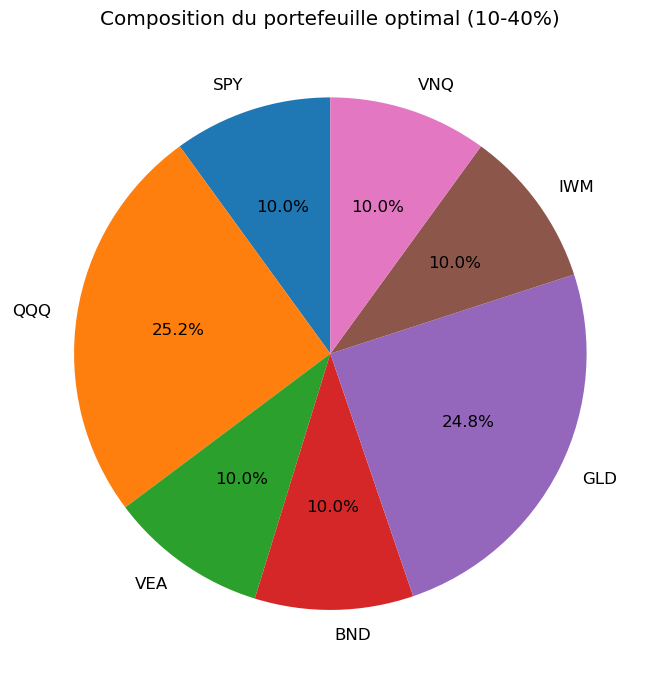

In [209]:
plt.figure(figsize=(7, 7))
plt.pie(best_weights_constr, labels=act_daily_ret_train_df.columns, autopct='%1.1f%%', startangle=90)
plt.title('Composition du portefeuille optimal (10-40%)')
plt.tight_layout()
plt.show()


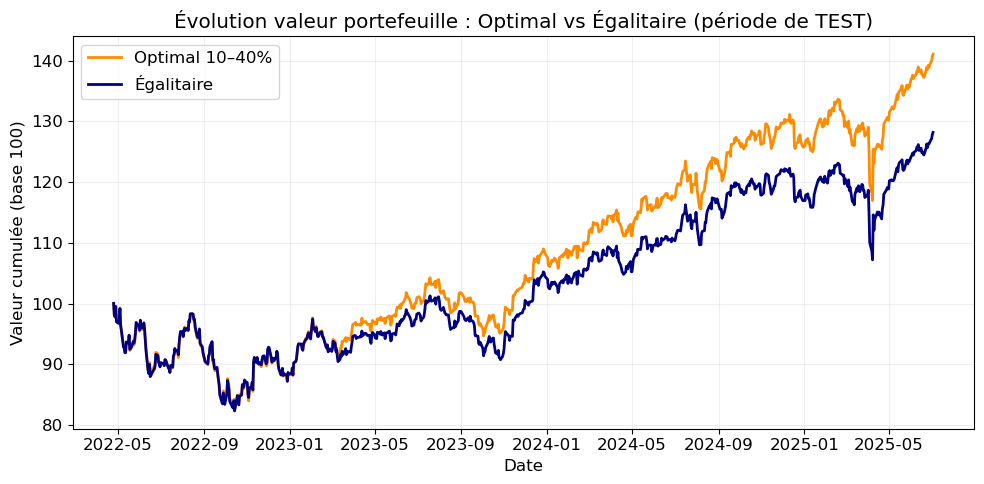

In [211]:
# Utilise la période de test (validation)
n = len(act_daily_ret_df.columns)
equal_weights = np.array([1/n]*n)

# Rendement quotidien du portefeuille égalitaire sur la période de test
port_ret_eq = act_daily_ret_df.dot(equal_weights)
cumulative_eq = (1 + port_ret_eq).cumprod() * 100

# Rendement quotidien du portefeuille optimal sur la même période
port_ret_opt = act_daily_ret_df.dot(best_weights_constr)
cumulative_opt = (1 + port_ret_opt).cumprod() * 100

plt.figure(figsize=(10,5))
plt.plot(cumulative_opt, lw=2, color='darkorange', label='Optimal 10–40%')
plt.plot(cumulative_eq, lw=2, color='navy', label='Égalitaire')
plt.title('Évolution valeur portefeuille : Optimal vs Égalitaire (période de TEST)')
plt.ylabel('Valeur cumulée (base 100)')
plt.xlabel('Date')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


In [215]:
# pred_daily_ret_df = DataFrame des rendements journaliers des prix prédits LSTM (période de test)
mean_returns_lstm = pred_daily_ret_df.mean()
cov_matrix_lstm   = pred_daily_ret_df.cov()


In [217]:
# Contraintes identiques à la partie historique
results_lstm_constr, weights_lstm_constr, _ = efficient_frontier_constrained(
    mean_returns_lstm, cov_matrix_lstm, risk_free=0.015, points=100, lb=0.1, ub=0.4
)


In [219]:
idx_sharpe_lstm = np.nanargmax(results_lstm_constr[2, :])
vol_sharpe_lstm = results_lstm_constr[0, idx_sharpe_lstm]
ret_sharpe_lstm = results_lstm_constr[1, idx_sharpe_lstm]


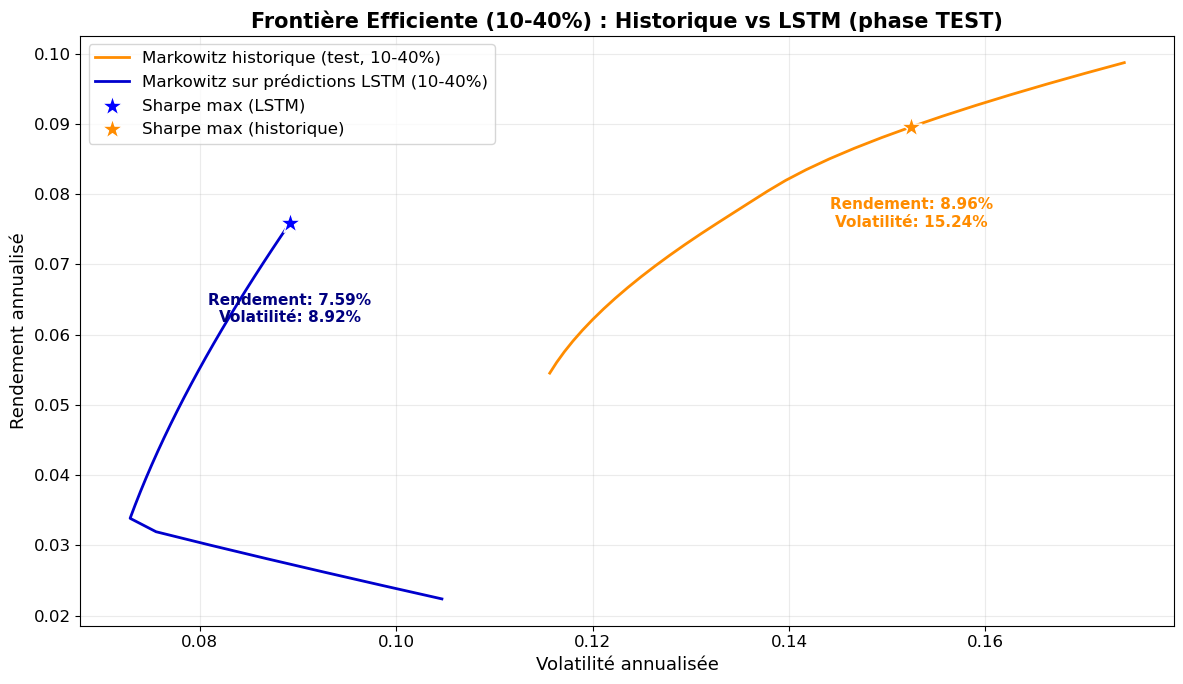


===== Poids optimaux (Sharpe max) sur la frontière LSTM =====
SPY: 10.00%
QQQ: 10.00%
VEA: 10.00%
BND: 11.16%
GLD: 38.84%
IWM: 10.00%
VNQ: 10.00%
Sharpe max (LSTM)       : 0.683

===== Poids optimaux (Sharpe max) sur la frontière Historique =====
SPY: 10.00%
QQQ: 25.24%
VEA: 10.00%
BND: 10.00%
GLD: 24.76%
IWM: 10.00%
VNQ: 10.00%
Sharpe max (historique) : 0.489


In [228]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# --- Courbes des deux frontières ---
plt.plot(results_constr[0, :], results_constr[1, :], '-', color='darkorange', lw=2, label='Markowitz historique (test, 10-40%)')
plt.plot(results_lstm_constr[0, :], results_lstm_constr[1, :], '-', color='mediumblue', lw=2, label='Markowitz sur prédictions LSTM (10-40%)')

# --- Points Sharpe max ---

# Sur la frontière LSTM
plt.scatter(vol_sharpe_lstm, ret_sharpe_lstm, c='blue', marker='*', s=250, edgecolors='white', zorder=5, label='Sharpe max (LSTM)')
plt.text(
    vol_sharpe_lstm, ret_sharpe_lstm - 0.01,
    f"Rendement: {ret_sharpe_lstm:.2%}\nVolatilité: {vol_sharpe_lstm:.2%}",
    fontsize=11, color='navy', ha='center', va='top', fontweight='bold'
)

# Sur la frontière historique
plt.scatter(vol_sharpe_hist, ret_sharpe_hist, c='darkorange', marker='*', s=250, edgecolors='white', zorder=5, label='Sharpe max (historique)')
plt.text(
    vol_sharpe_hist, ret_sharpe_hist - 0.01,
    f"Rendement: {ret_sharpe_hist:.2%}\nVolatilité: {vol_sharpe_hist:.2%}",
    fontsize=11, color='darkorange', ha='center', va='top', fontweight='bold'
)

plt.xlabel('Volatilité annualisée', fontsize=13)
plt.ylabel('Rendement annualisé', fontsize=13)
plt.title('Frontière Efficiente (10-40%) : Historique vs LSTM (phase TEST)', fontsize=15, fontweight='bold')
plt.grid(alpha=0.25)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()

# ========== Impression des résultats ==========
print("\n===== Poids optimaux (Sharpe max) sur la frontière LSTM =====")
best_weights_lstm = weights_lstm_constr[idx_sharpe_lstm]
for t, w in zip(pred_daily_ret_df.columns, best_weights_lstm):
    print(f"{t}: {w:.2%}")

print(f"Sharpe max (LSTM)       : {results_lstm_constr[2, idx_sharpe_lstm]:.3f}")

print("\n===== Poids optimaux (Sharpe max) sur la frontière Historique =====")
best_weights_hist = weights_constr[idx_sharpe_hist]
for t, w in zip(act_daily_ret_df.columns, best_weights_hist):
    print(f"{t}: {w:.2%}")

print(f"Sharpe max (historique) : {results_constr[2, idx_sharpe_hist]:.3f}")


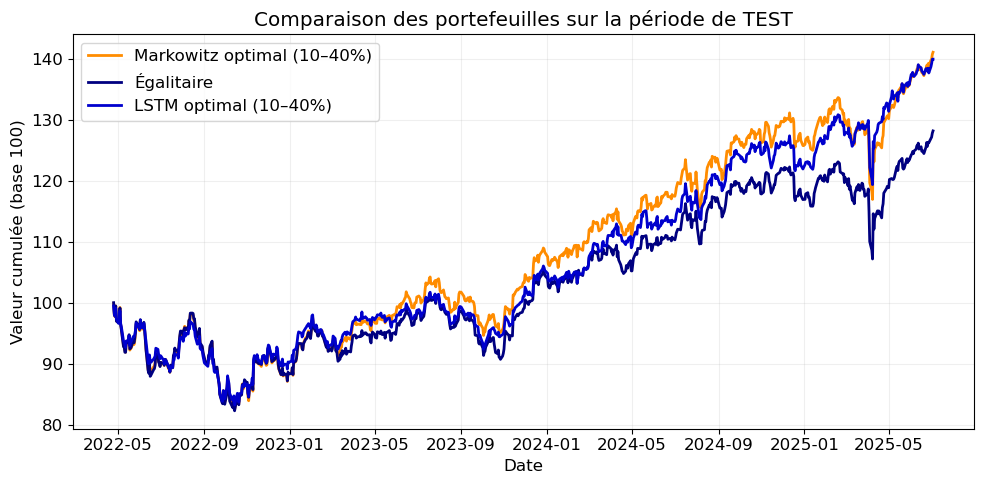

In [226]:
# - act_daily_ret_df : rendements journaliers RÉELS sur la période de TEST/validation (801 lignes x 7 actifs)
# - best_weights_constr : poids Markowitz optimaux (optimisés sur train)
# - best_weights_lstm   : poids optimisés LSTM (optimisés sur prédictions sur test)
# - equal_weights       : portefeuille égalitaire (1/N)
# Poids optimaux du portefeuille LSTM sur la frontière efficiente des prédictions
best_weights_lstm = weights_lstm_constr[idx_sharpe_lstm]

n = len(act_daily_ret_df.columns)
equal_weights = np.array([1/n]*n)

# Portefeuille Markowitz classique
port_ret_markowitz = act_daily_ret_df.dot(best_weights_constr)
cumulative_markowitz = (1 + port_ret_markowitz).cumprod() * 100

# Portefeuille Égalitaire
port_ret_eq = act_daily_ret_df.dot(equal_weights)
cumulative_eq = (1 + port_ret_eq).cumprod() * 100

# Portefeuille LSTM (poids issus de la frontière efficiente LSTM)
port_ret_lstm = act_daily_ret_df.dot(best_weights_lstm)
cumulative_lstm = (1 + port_ret_lstm).cumprod() * 100

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(cumulative_markowitz, lw=2, color='darkorange', label='Markowitz optimal (10–40%)')
plt.plot(cumulative_eq, lw=2, color='navy', label='Égalitaire')
plt.plot(cumulative_lstm, lw=2, color='mediumblue', label='LSTM optimal (10–40%)')
plt.title('Comparaison des portefeuilles sur la période de TEST')
plt.ylabel('Valeur cumulée (base 100)')
plt.xlabel('Date')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

